In [9]:
import sys
# adding notebooks to the system path
sys.path.insert(0, '/home/southark/notebooks')


import os
os.environ["OMP_NUM_THREADS"] = "20"
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from umap import UMAP
from perturbseq import *

import scanpy as sc

import gseapy as gp
from gseapy import barplot,  dotplot


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from hits.visualize import interactive
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

# Load on target activation and expression matricies

In [11]:
path = '/data/norman/southark/tfs_standardized/'

datasets = ['rpe1_a', 'fibro_a']

on_target = {}
pctl_pops = {}
coef_pops = {}

for data in datasets:
    if data == 'rpe1_a':
        filename_ot = '20240318_RPE1_final_low_UMI_count_regressions_coef_on_target_activation_percentile_phenotype.csv'
        filename_pctl = '20240318_RPE1_final_low_UMI_count_regressions_coef_percentile_expression_changes_all_genes.hdf'
        filename_coefs = '20240309_RPE1_CRISPRa_mean_pop.hdf'
    elif data == 'fibro_a':
        filename_ot = '20240318_fibroblast_final_low_UMI_count_regressions_coef_on_target_activation_percentile_phenotype.csv'
        filename_pctl = '20240318_fibroblast_final_low_UMI_count_regressions_coef_percentile_expression_changes_all_genes.hdf'
        filename_coefs = '20240311_fibroblast_CRISPRa_mean_pop.hdf'
    on_target[data] = pd.read_csv(f'{path}{filename_ot}')
    pctl_pops[data] = CellPopulation.from_hdf(f'{path}{filename_pctl}')
    coef_pops[data] = CellPopulation.from_hdf(f'{path}{filename_coefs}')
    
    
atac_data = pd.read_csv('/data/norman/southark/rpe1_tfs/epigenetics/all_genes_ATAC_hs27+rpe1.csv')

hs27_atac = atac_data.groupby('gene').HS27_ATAC.mean()
rpe1_atac = atac_data.groupby('gene').RPE1_ATAC.mean()

#add atac data as var metadata

# Ensure that the 'guide_identity' is set as the index of metadata_df for the merge
#metadata_atac = rpe1_atac

# Merge the metadata_df with cell pop
pctl_pops['rpe1_a'].genes = pctl_pops['rpe1_a'].genes.merge(rpe1_atac, left_on='gene_name', right_index=True, how='left')
pctl_pops['fibro_a'].genes = pctl_pops['fibro_a'].genes.merge(hs27_atac, left_on='gene_name', right_index=True, how='left')


pctl_pops['rpe1_a'].genes['inaccessible'] = pctl_pops['rpe1_a'].genes.RPE1_ATAC < 5
pctl_pops['fibro_a'].genes['inaccessible'] = pctl_pops['fibro_a'].genes.HS27_ATAC < 5

Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix', '/normalized_matrix_adj_p', '/normalized_matrix_count_profile', '/normalized_matrix_naive_mean_profile', '/normalized_matrix_p', '/normalized_matrix_pctl_expr', '/normalized_matrix_reconstruction']
Loading metadata...
Done in 83.11051535606384s.
Done.
Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix', '/normalized_matrix_adj_p', '/normalized_matrix_masked', '/normalized_matrix_p']
Loading metadata...
Done in 6.953258275985718s.
Done.
Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix', '/normalized_matrix_adj_p', '/normalized_matrix_count_profile', '/normalized_matrix_naive_mean_profile', '/normalized_matrix_p', '/normalized_matrix_pctl_expr', '/normalized_matrix_reconstruction']
Loading metadata...
Done in 81.38783144950867s.
Done.
Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix', '/normalized_matrix_adj_p', '/normalized_matrix_masked', '/normal

In [12]:
guides_merged = pd.read_csv('/data/norman/southark/tfs_standardized/20240318_merged_morf_tf_lib_guide_activity_classifications_final_low_UMI_count_regressions_coef.csv')
guides_merged = guides_merged[guides_merged.primary_target].set_index('guide_identity')

# Mask activated genes and record metadata

In [13]:
def optimize_analyze_cell_population(cell_pop, fdr=0.01, count_thres=3, expr_thres=15):
    # Filter cells DataFrame to include only relevant cells
    #relevant_cells = cell_pop.cells.index.isin(cell_pop.normalized_matrix['adj_p'].index)
    #cell_pop.cells = cell_pop.cells[relevant_cells]
    
    # Ensure 'adj_p' DataFrame and 'cells' DataFrame have aligned indices
    # Assuming 'cell_pop.cells' and 'cell_pop.normalized_matrix['adj_p']' are both DataFrames
    # and their indices should match
    relevant_indices = cell_pop.cells.index.intersection(cell_pop.normalized_matrix['adj_p'].index)
    cell_pop.cells = cell_pop.cells.loc[relevant_indices]
    adj_p_filled = cell_pop.normalized_matrix['adj_p'].loc[relevant_indices].fillna(1)

    # Directly compute control percentile from 'pctl_expr' matrix
    control_pctl = cell_pop.normalized_matrix['pctl_expr'].loc['control']
    
    accessibility = cell_pop.genes.reindex(cell_pop.normalized_matrix['adj_p'].columns)['inaccessible']
    
    # Pre-compute 'adj_p_filled' to avoid filling NaNs multiple times
    adj_p_filled = cell_pop.normalized_matrix['adj_p'].fillna(1)

    # Vectorized operation to compute percentile change for all genes relative to control
    pct_change = cell_pop.normalized_matrix['pctl_expr'].subtract(control_pctl, axis=1)

    # Calculate masks using conditions
    turned_on_mask = (adj_p_filled < fdr) & \
                     (pct_change > 0) & \
                     (cell_pop.normalized_matrix['count_profile'].loc[relevant_indices]  >= count_thres) & \
                     (control_pctl < expr_thres)
    
    # Calculate masks using conditions
    turned_on_atac = (adj_p_filled < fdr) & \
                     (pct_change > 0) & \
                     (cell_pop.normalized_matrix['count_profile'] >= count_thres) & \
                     (control_pctl < expr_thres)&\
                     (accessibility == True)
    
    sig_up = (adj_p_filled < fdr) & \
                      (pct_change >= 5) & \
                      (cell_pop.normalized_matrix['count_profile'] >= count_thres)

    sig_high_change = (adj_p_filled < fdr) & \
                      (pct_change >= 15) & \
                      (cell_pop.normalized_matrix['count_profile'] >= count_thres)

    upregulated_mask = (adj_p_filled < fdr) & \
                       (pct_change > 0) & \
                       (cell_pop.normalized_matrix['count_profile'] >= count_thres)

    cell_pop.normalized_matrix['on_mask'] = turned_on_mask
    cell_pop.normalized_matrix['on_mask_atac'] = turned_on_atac
    cell_pop.normalized_matrix['upregulated_mask'] = upregulated_mask
    cell_pop.normalized_matrix['sig_up'] = sig_up
    cell_pop.normalized_matrix['sig_high_change'] = sig_high_change

    # Summary/Metadata calculations for cells
    cell_pop.cells['num_genes_on'] = turned_on_mask.sum(axis=1)
    cell_pop.cells['num_genes_sig_up'] = sig_high_change.sum(axis=1)

    # Summary/Metadata calculations for genes
    cell_pop.genes['num_guides_on'] = turned_on_mask.sum(axis=0)
    cell_pop.genes['num_guides_sig_up'] = sig_high_change.sum(axis=0)
    cell_pop.genes['num_guides_upregulated'] = upregulated_mask.sum(axis=0)

    #filter to good guides
    good_guides = cell_pop.cells['good_guide'] == True  # Assuming 'good_guide' is a boolean column in 'genes'
    
    cell_pop.genes['num_guides_on_filtered'] = turned_on_mask.loc[good_guides,:].sum(axis=0)
    cell_pop.genes['num_guides_on_atac_filtered'] = turned_on_atac.loc[good_guides,:].sum(axis=0)
    cell_pop.genes['num_guides_sig_up_filtered'] = sig_up.loc[good_guides,:].sum(axis=0)
        
    #filter to bad seed
    bad_seed = (cell_pop.cells['bad_seed'] == True) | (cell_pop.cells['seed_driven'] == True)
    
    #summarize bad seed conditions
    cell_pop.genes['num_guides_on_bad_seed'] = turned_on_mask.loc[bad_seed ,:].sum(axis=0).sum(axis = 0)
    cell_pop.genes['num_guides_on_atac_bad_seed'] = turned_on_atac.loc[bad_seed,:].sum(axis=0).sum(axis = 0)
    cell_pop.genes['num_guides_sig_up_bad_seed'] = sig_up.loc[bad_seed,:].sum(axis = 0)

    # Threshold-based gene metadata
    cell_pop.genes['on_filtered'] = cell_pop.genes['num_guides_on_filtered'] >= 2

    cell_pop.genes['on_bad_seed'] = cell_pop.genes['num_guides_on_bad_seed'] >= 2
    cell_pop.genes['sig_up_bad_seed'] = cell_pop.genes['num_guides_sig_up_bad_seed'] >= 2

    # Control expression based metadata
        
    cell_pop.genes['ctrl_pctl'] = cell_pop.genes.index.map(cell_pop.cells['ctrl_pctl'])
    cell_pop.genes['control_expressed'] = cell_pop.genes['ctrl_pctl'] >= expr_thres

    # Return the cell_pop with updated analyses and summaries
    return cell_pop

In [14]:
analysis_results_dict = {}

for key, cell_pop in pctl_pops.items():
    
    cell_pop.cells['seed_driven'] = cell_pop.cells.masked_cluster_description.str.contains('SEQUENCE-driven')
    cell_pop.cells['bad_seed'] = guides_merged.bad_seed
    cell_pop.cells['good_guide'] = (cell_pop.cells['bad_seed'] == False)&\
                                    (cell_pop.cells['seed_driven'] == False)&\
                                    ((cell_pop.cells['is_activated'] == True)|(cell_pop.cells['masked_active'] == True))
    
    analysis_results = optimize_analyze_cell_population(cell_pop, fdr=0.01, count_thres=3, expr_thres=15)
    analysis_results_dict[key] = analysis_results

In [15]:
analysis_results_dict['fibro_a'].normalized_matrix['upregulated_mask']

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288172,ENSG00000288187,ENSG00000288235,ENSG00000288253,ENSG00000288321,ENSG00000288380,ENSG00000288398,ENSG00000288436,ENSG00000288460,control
AATF_GCGCAGAAGGTTGAAGGGAT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,NaN
AATF_GCGTGCGAGTGCGCGGGAAG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,NaN
AATF_GGAAGCGCGCAGAAGGTTGA,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,NaN
AATF_GGAAGGGATTGGAGCCGTAT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,NaN
AATF_GGGCGTTGCTAGCATGAAGG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
off-target_GTCCATAGGGTCTAGCGCCG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,NaN
off-target_GTCGTTATCTCGCTATTTCG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,NaN
off-target_GTGGATTATCTGACGCGAAT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,NaN
off-target_GTGGTTATACCCGACTAGAC,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,NaN


# Compile High Confidence Lists of Genes Turned On/Signifigantly up

There are a few ways to do this, here doing:
1. genes turned on by guides to the same gene: **record number of guides turning on

In [20]:
#filtering the activated genes for consistent activated across at least the min num of guides
def optimize_genes_activation_with_counts(analysis_result,pop_filter = 'good_guide == True',  min_activation_count=1, activation_mask = "on_mask"):
    cell_pop = analysis_result
    good_guides_indices = cell_pop.cells.query(pop_filter).index

    sig_up_genes = cell_pop.normalized_matrix[activation_mask]

    genes_act_per_target_filtered = {}
    targets_to_genes_counts = {}  # New dictionary to store counts of guides activating genes
    guide_targets = cell_pop.cells.loc[good_guides_indices, 'target_gene'].unique()
    
    for g in guide_targets:
        TARGET_indices = cell_pop.cells.query(pop_filter+'&(target_gene == @g)').index.to_list()

        
        turned_on_counts = sig_up_genes.loc[TARGET_indices].sum()
        gene_id = cell_pop.genes.query('gene_name == @g').index
        
        # Filter for counts > 1 and exclude the current target gene
        filtered_genes = turned_on_counts[turned_on_counts >= min_activation_count].index.difference(gene_id)
        genes_act_per_target_filtered[g] = cell_pop.genes.loc[filtered_genes, 'gene_name'].tolist()

        #Populate targets_to_genes_counts with actual counts for all genes
        for gene in turned_on_counts[turned_on_counts >= min_activation_count].index.difference(gene_id):  # Exclude the current target gene
            gene_name = cell_pop.genes.loc[gene, 'gene_name']
            if g not in targets_to_genes_counts:
                targets_to_genes_counts[g] = {}
            targets_to_genes_counts[g][gene_name] = turned_on_counts[gene]
        
    # Create DataFrame from targets_to_genes_counts for actual counts
    activation_counts_df = pd.DataFrame.from_dict(targets_to_genes_counts, orient='index').fillna(0)
    activation_counts_df.index.name = 'target_gene'

    return genes_act_per_target_filtered, activation_counts_df

## Genes turned on collapsed to target (all, atac etc), masked active & good guide filter

In [21]:
output_path = '/data/norman/southark/tfs_standardized/'
date = '20240403'

genes_activated_dict = {}
genes_activated_df = {}
#genes_activated_rpe1 = {}

# min_activation = 1
# act_mask = 'on_mask_atac'

#conditions tuple of filter/

conditions = [(1, 'on_mask_atac'), (2, 'on_mask_atac'), (1, 'on_mask'), (2, 'on_mask'), 
              (1, 'sig_up'), (2, 'sig_up'),
              (1, 'upregulated_mask'),(2, 'upregulated_mask')
             ]

for name, pop in analysis_results_dict.items():
    
    genes_activated_dict[name] = {}
    genes_activated_df[name] = {}
    #apply various filter combos
    for min_activation, act_mask in conditions:
        genes_activation_dict, activation_counts_df = optimize_genes_activation_with_counts(
                                                                            pop,
                                                                            pop_filter = '(good_guide == True)&(masked_active ==True)',
                                                                            min_activation_count=min_activation,
                                                                            activation_mask = act_mask)
        record_filter = 'min' +str(min_activation)
        record_combo = f'{act_mask}_{record_filter}'
        
        genes_activated_dict[name][record_combo] = genes_activation_dict
        genes_activated_df[name][record_combo] = activation_counts_df
    
        # Now, activation_counts_df is ready for further analysis or export
        activation_counts_df.to_csv(f'{output_path}/{date}_{name}_gene_activation_counts_per_target_{record_combo}_masked_active.csv', index=False)

### Pioneering Score: Target Aggregation

## Color Palette

1. #864D9E - A deep purplish hue.
2. #376ADC - A softened medium blue with reduced saturation.
3. #AE5981 - A muted pinkish-purple.
4. #5AC2B0 - A teal or turquoise-like color.
5. #D99828 - A golden yellow.
6. #528FF0 - A light blue shade.

In [23]:
def calc_pioneering(genes_activated_df):
    #takeing the sum of genes activated as pioneering
    pioneering_scores = {}

    for name, df_dict in genes_activated_df.items():

        pioneering_scores[name] = {}

        for subset, df in df_dict.items():
            pioneering_scores[name][subset] = df.sum(axis = 1)
            
    return pioneering_scores

In [24]:
pioneering_scores = calc_pioneering(genes_activated_df)

pioneering_rpe1 = pd.DataFrame(pioneering_scores['rpe1_a'])
pioneering_fibro = pd.DataFrame(pioneering_scores['fibro_a'])

pioneering_rpe1['cell_type'] = 'RPE1'
pioneering_fibro['cell_type'] = 'Hs27'

pioneering_comb = pd.concat([pioneering_rpe1.reset_index(), pioneering_fibro.reset_index()], ignore_index = True)
pioneering_comb

,target_gene,on_mask_atac_min1,on_mask_atac_min2,on_mask_min1,on_mask_min2,sig_up_min1,sig_up_min2,upregulated_mask_min1,upregulated_mask_min2,cell_type
0,ALX1,11.0,NaN,25.0,NaN,76.0,NaN,166.0,NaN,RPE1
1,ALX4,14.0,2.0,35.0,4.0,128.0,18.0,489.0,126.0,RPE1
2,ARID1A,10.0,NaN,25.0,2.0,41.0,2.0,43.0,2.0,RPE1
3,ARID3A,7.0,NaN,29.0,NaN,48.0,NaN,56.0,4.0,RPE1
4,ARID5B,8.0,NaN,26.0,NaN,32.0,NaN,33.0,NaN,RPE1
...,...,...,...,...,...,...,...,...,...,...
361,ZNF618,8.0,NaN,38.0,NaN,103.0,NaN,214.0,4.0,Hs27
362,ZNF697,NaN,NaN,3.0,NaN,17.0,NaN,17.0,NaN,Hs27
363,ZNF711,2.0,NaN,12.0,NaN,57.0,NaN,62.0,NaN,Hs27
364,ZNF777,1.0,NaN,2.0,NaN,60.0,2.0,60.0,2.0,Hs27


## On Min 2 Fibro

/tmp/ipykernel_372000/2785174887.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_subset['cell_type'] =  outlier_subset['cell_type'].cat.remove_unused_categories()
/tmp/ipykernel_372000/2785174887.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_subset['cell_type'] =  outlier_subset['cell_type'].cat.remove_unused_categories()
/tmp/ipykernel_372000/2785174887.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

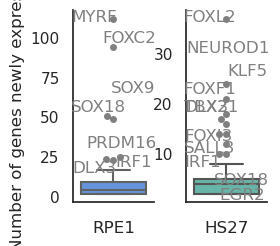

In [689]:
from adjustText import adjust_text
sns.set_context('paper', font_scale = 1)
# Plot settings
sns.set(style="white")
sns.set_palette('colorblind')

#plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'


# Assume df is your DataFrame from the previous example
df = pioneering_comb#.fillna(0) #pioneering_masked_active


df['cell_type'] = df['cell_type'].astype('category')
df['target_gene'] = df['target_gene'].astype('category')

value = 'on_mask_min2' #which col to use for values

# Create an empty DataFrame to hold outliers
outliers_df = pd.DataFrame(columns=df.columns)

groups = ['RPE1', 'Hs27']


outliers_dfs = {}
# Calculate outliers for each group and append them to outliers_df
for group in ['RPE1', 'Hs27']:
    subset = df[df['cell_type'] == group]
    q1 = subset[value].quantile(0.25)
    q3 = subset[value].quantile(0.75)
    iqr = q3 - q1
    # Filtering outliers
    outlier_subset = subset[(subset[value] < (q1 - 1.5 * iqr)) | (subset[value] > (q3 + 1.5 * iqr))]
    
    outlier_subset['cell_type'] =  outlier_subset['cell_type'].cat.remove_unused_categories()
    outliers_dfs[group] = outlier_subset

RPE1_data = df[df['cell_type'] == 'RPE1']
RPE1_data['cell_type'] = RPE1_data['cell_type'].cat.remove_unused_categories()

fibro_data = df[df['cell_type'] == 'Hs27']
fibro_data['cell_type'] = fibro_data['cell_type'].cat.remove_unused_categories()

# Create a figure with two subplots with shared y-axes
fig, axes = plt.subplots(1, 2, figsize=(2.5, 2.5), sharey=False, gridspec_kw={'width_ratios': [1, 1]})

# Left plot for rpe1_a
sns.boxplot(x='cell_type', y=f'{value}', data=RPE1_data, ax=axes[0], color="#528FF0", showfliers=False)
sns.swarmplot(x='cell_type', y=f'{value}', data=outliers_dfs['RPE1'], 
              color='black', alpha=0.5, ax=axes[0])

# Right plot for fibro_a
sns.boxplot(x='cell_type', y=f'{value}', data=fibro_data, ax=axes[1], color="#5AC2B0", showfliers=False)
sns.swarmplot(x='cell_type', y=f'{value}', data=outliers_dfs['Hs27'], 
              color='black', alpha=0.5, ax=axes[1])


for ax, group in zip(axes, groups):
    outlier_subset = outliers_dfs[group]
    
    texts = []
    
    for index, row in outlier_subset.iterrows():
        # Add text annotation
        texts.append(ax.text(x=row['cell_type'], y=row[value], s=row['target_gene'], color='grey', ha='right'))

    # Adjust text to not overlap
    adjust_text(texts, ax=ax)  # Provide the axes to adjust_text if needed for better layout management

# Titles for each subplot
axes[0].set_xlabel('RPE1')
axes[1].set_xlabel('HS27')

# Set the labels (if you want to keep the y-label only on the left plot, adjust accordingly)
axes[0].set_ylabel('Number of genes newly expressed')
axes[1].set_ylabel('')

# Set the x-tick labels to empty since they are not meaningful in this context
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

# Adjust the subplot parameters to give some space between the plots
plt.subplots_adjust(wspace=0.4)

# Use despine to remove the right and top borders
sns.despine()


plt.savefig(f'/data/norman/southark/tfs_standardized/figure_exports/newly_expressed_genes_boxplots_{value}.svg')

# Show the plot
plt.show()

74
11


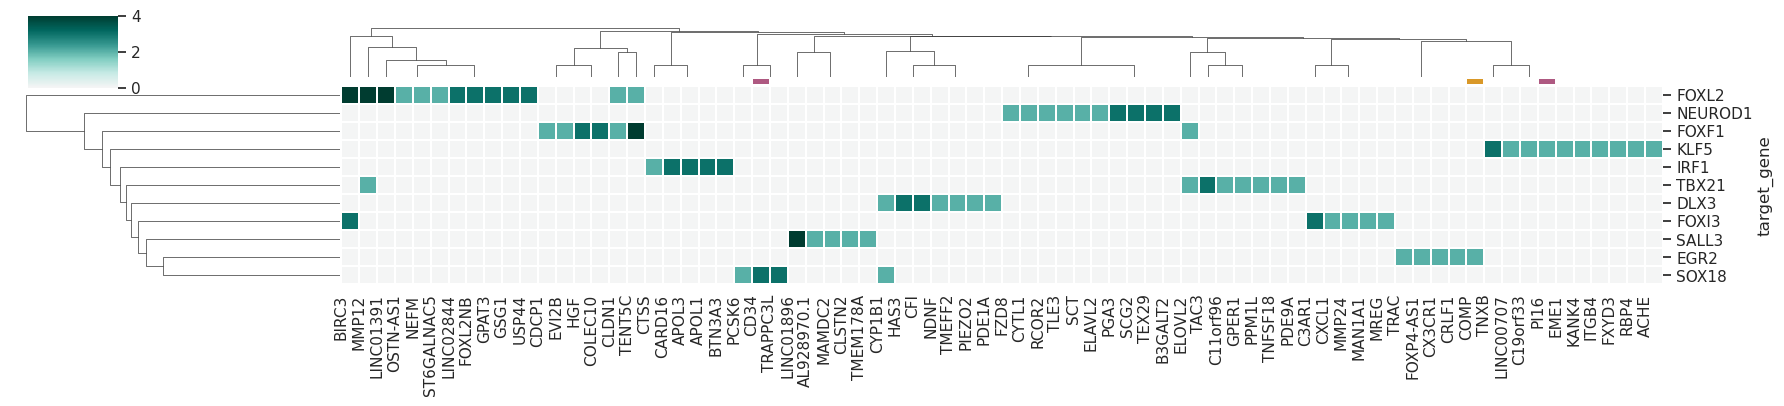

In [690]:
target_matrix = genes_activated_df['fibro_a'][value]

num_guides_on = 1 #filter for min num of guides that gene in on in
num_genes_activated = 3
num_targets_gene_on = 1

filtered_targets = target_matrix.loc[outliers_dfs['Hs27'].target_gene]
#filtered_targets = target_matrix.loc[target_matrix[target_matrix >= num_guides_on].sum(axis = 1) > num_genes_activated ]



#filter columns
filtered_genes = filtered_targets.columns[(filtered_targets >= num_guides_on).sum() >= num_targets_gene_on]

genes_of_interest = [
                     'PI16', #universal marker
                     #defined steady state atlas cluster markers
                     'COMP', #
                     'CCL19',
                     'COCH',
                     'CXCL12',
                     'FBLN1',
                     'BMP4',
                     'NPNT',
                     'HHIP'
                     #universal Dpt+Col15a1+
                     'DPT',
                     'COL15A1',
                     #named clusters Korsunsky 2022
                     'CD34',
                     'MFAP5',
                     'CXCL10',
                     'CCL19',
                     'FBLN1',
                     'MYH11',
                     'PTGS2',
                     'SEMA4A',
                     'SPARC',
                     'COL3A1'
                    ]

# Your existing code for filtering
# ...

# Create a color label for each gene in 'filtered_genes'
col_colors = filtered_genes.map(lambda x: "#AE5981" if x == 'PI16' or x == 'CD34' else '#D99828' if x in genes_of_interest else 'white')#.tolist()
#col_colors = filtered_genes.map(lambda x: '#D99828' if x in genes_of_interest else 'white').tolist()



print(len(filtered_genes))
print(len(filtered_targets.index))

g = sns.clustermap(filtered_targets[filtered_genes], linewidths=0.01,linecolor='white',
               figsize = (18,4), cmap = 'BrBG', center = 0, #BrBG
               vmax = 4, robust = True,
              col_colors=col_colors)

# Get the order of the columns from the clustermap's result
clustered_cols = g.data2d.columns.tolist()

num_columns = filtered_targets[filtered_genes].shape[1]
g.ax_heatmap.set_xticks(range(num_columns))


# Apply the labels in the clustered order
g.ax_heatmap.set_xticklabels(clustered_cols, rotation=90)

# Rotate x-axis labels for clarity
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
g.ax_heatmap.xaxis.set_tick_params(pad=1)  # Adjust spacing if needed



# # Get the number of columns in the data to set ticks for each column
# num_columns = filtered_targets[filtered_genes].shape[1]
# g.ax_heatmap.set_xticks(range(num_columns))

# # Set labels directly with all column names
# g.ax_heatmap.set_xticklabels(filtered_targets[filtered_genes].columns, rotation=90)


# plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
# g.ax_heatmap.xaxis.set_tick_params(pad=0)  # Reducing space between ticks and labels


plt.savefig(f'/data/norman/southark/tfs_standardized/figure_exports/20240417_newly_expressed_genes_heatmap_{value}_wide.svg')


## On min 2 RPE1

137
7


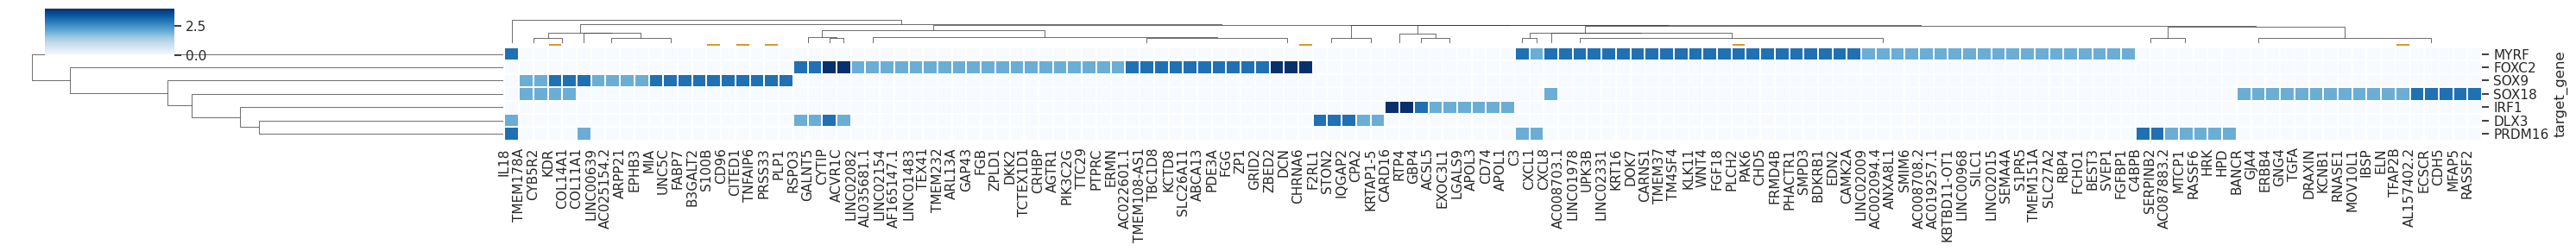

In [703]:
target_matrix = genes_activated_df['rpe1_a'][value]

num_guides_on = 1 #filter for min num of guides that gene in on in
num_genes_activated = 3
num_targets_gene_on = 1

filtered_targets = target_matrix.loc[outliers_dfs['RPE1'].target_gene]
#filtered_targets = target_matrix.loc[target_matrix[target_matrix >= num_guides_on].sum(axis = 1) > num_genes_activated ]


genes_of_interest = retina_markers.tolist()+additional_rpe+additional_other



#filter columns
filtered_genes = filtered_targets.columns[(filtered_targets >= num_guides_on).sum() >= num_targets_gene_on]

gene_of_interest = []#fill
# Your existing code for filtering
# ...

# Create a color label for each gene in 'filtered_genes'
col_colors = filtered_genes.map(lambda x: "#AE5981" if x == 'PI16' or x == 'CD34' else '#D99828' if x in genes_of_interest else 'white')#.tolist()
#col_colors = filtered_genes.map(lambda x: '#D99828' if x in genes_of_interest else 'white').tolist()



print(len(filtered_genes))
print(len(filtered_targets.index))

g = sns.clustermap(filtered_targets[filtered_genes], linewidths=0.01,linecolor='white',
               figsize = (30,3), cmap = 'Blues',# center = 0, #BrBG
               vmax = 4, robust = True,
              col_colors=col_colors)

# Get the order of the columns from the clustermap's result
clustered_cols = g.data2d.columns.tolist()

num_columns = filtered_targets[filtered_genes].shape[1]
g.ax_heatmap.set_xticks(range(num_columns))


# Apply the labels in the clustered order
g.ax_heatmap.set_xticklabels(clustered_cols, rotation=90)

# Rotate x-axis labels for clarity
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
g.ax_heatmap.xaxis.set_tick_params(pad=0)  # Adjust spacing if needed

plt.savefig(f'/data/norman/southark/tfs_standardized/figure_exports/240417_rpe1_newly_expressed_genes_heatmap_{value}_wide.svg')


Import rential markers

In [686]:
retina_genes = pd.read_csv('/data/norman/southark/gene_sets/hpa/retina_norm_df_filtered_90pctl_celltype_scores.csv')

retina_markers = retina_genes.sort_values('retina', ascending = False).head(500)['Gene name']

In [702]:
additional_rpe = ['ABCA4', 'AIPL1', 'ANO2', 'APOE', 'AQP4', 'ARR3', 'BCO2', 'BEST1', 'CABP5', 'CAMK2B', 'CLU', 'CPLX4', 'CRB2', 'CRISPLD1', 'CRX', 'CST3', 'DCT', 'EFEMP1', 'ENPP2', 'FOXA2', 'GFAP', 'GLUL', 'GNAT1SAG', 'GNAT2', 'GNG13', 'GNGT1', 'GNGT2', 'GPR37L110', 'GRM6', 'GUCA1B', 'GULP1', 'ITGAV', 'ITGB8', 'KCNJ10', 'KCNJ6', 'KRT18', 'KRT8', 'LHX1', 'LRAT', 'MERTK', 'MITF', 'NES', 'NG2', 'NR2E3', 'NRL', 'NURR1', 'OCA2', 'ONECUT1', 'ONECUT2', 'OPN1LW', 'OPN1MW', 'OPN1MW3', 'OTX2', 'PAX6', 'PDC', 'PDE6A', 'PDE6G', 'PPEF2', 'PTGDS', 'RAX', 'RBP1', 'RCVRN', 'RDH12', 'RDH5', 'REC', 'RGR', 'RHO', 'RLBP1', 'RLPB1', 'RPE65', 'S100B', 'SAMD7', 'SERPINF1', 'SIX6', 'SLC16A8', 'SLC18A2', 'SLC6A3', 'SMIM40', 'TH', 'TMEM221', 'TRP1', 'TRP2', 'TRPM1', 'TUBB3', 'TUJ1', 'TXNIP', 'TYR', 'TYRP1', 'VEGFA', 'VIM', 'VSX2']
additional_other = ['ACTA2', 'ACTG2', 'ADH7', 'AIF1', 'ALDH1L1', 'APOE', 'CAMK2B', 'CLU', 'CNN1', 'COL17A1', 'COL3A1', 'CRNN', 'CUX2', 'DCT', 'FBN1', 'GAD1', 'GFAP', 'GJA1', 'GLUL', 'GNAT2', 'GPR17', 'GRM6', 'ITGAM', 'KRT1', 'KRT10', 'KRT14', 'KRT15', 'KRT5', 'KRT6A', 'KRTDAP', 'LHX1', 'LUM', 'MB', 'MBP', 'MLANA', 'MME', 'MOG', 'MPZ', 'MYH11', 'MYH2', 'MYH7', 'MYL2', 'MYL7', 'NG2', 'NR2E3', 'NRGN', 'ONECUT1', 'ONECUT2', 'OPN1LW', 'OPN1MW', 'P2RY12', 'PDE6A', 'PVALB', 'S100B', 'SAG', 'SLC17A7', 'SLC1A3', 'SLC32A1', 'SOX10', 'SST', 'TBR1', 'TRPM1', 'TTN', 'TYROBP', 'TYRP1', 'VIP', 'ZEB1']


# On atac min1 (pioneering)

In [43]:
# from adjustText import adjust_text
# sns.set_context('paper', font_scale = 1)
# # Plot settings
# sns.set(style="white")
# sns.set_palette('colorblind')

# #plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['svg.fonttype'] = 'none'


# # Assume df is your DataFrame from the previous example
# df = pioneering_comb#.fillna(0) #pioneering_masked_active


# df['cell_type'] = df['cell_type'].astype('category')
# df['target_gene'] = df['target_gene'].astype('category')

# value = 'on_mask_atac_min1' #which col to use for values

# # Create an empty DataFrame to hold outliers
# outliers_df = pd.DataFrame(columns=df.columns)

# groups = ['RPE1', 'Hs27']


# outliers_dfs = {}
# # Calculate outliers for each group and append them to outliers_df
# for group in ['RPE1', 'Hs27']:
#     subset = df[df['cell_type'] == group]
#     q1 = subset[value].quantile(0.25)
#     q3 = subset[value].quantile(0.75)
#     iqr = q3 - q1
#     # Filtering outliers
#     outlier_subset = subset[(subset[value] < (q1 - 1.5 * iqr)) | (subset[value] > (q3 + 1.5 * iqr))]
    
#     outlier_subset['cell_type'] =  outlier_subset['cell_type'].cat.remove_unused_categories()
#     outliers_dfs[group] = outlier_subset

# RPE1_data = df[df['cell_type'] == 'RPE1']
# RPE1_data['cell_type'] = RPE1_data['cell_type'].cat.remove_unused_categories()

# fibro_data = df[df['cell_type'] == 'Hs27']
# fibro_data['cell_type'] = fibro_data['cell_type'].cat.remove_unused_categories()

# # Create a figure with two subplots with shared y-axes
# fig, axes = plt.subplots(1, 2, figsize=(4, 4), sharey=False, gridspec_kw={'width_ratios': [1, 1]})

# # Left plot for rpe1_a
# sns.boxplot(x='cell_type', y=f'{value}', data=RPE1_data, ax=axes[0], color="#528FF0", showfliers=False)
# sns.swarmplot(x='cell_type', y=f'{value}', data=outliers_dfs['RPE1'], 
#               color='black', alpha=0.5, ax=axes[0])

# # Right plot for fibro_a
# sns.boxplot(x='cell_type', y=f'{value}', data=fibro_data, ax=axes[1], color="#5AC2B0", showfliers=False)
# sns.swarmplot(x='cell_type', y=f'{value}', data=outliers_dfs['Hs27'], 
#               color='black', alpha=0.5, ax=axes[1])


# for ax, group in zip(axes, groups):
#     outlier_subset = outliers_dfs[group]
    
#     texts = []
    
#     for index, row in outlier_subset.iterrows():
#         # Add text annotation
#         texts.append(ax.text(x=row['cell_type'], y=row[value], s=row['target_gene'], color='grey', ha='right'))

#     # Adjust text to not overlap
#     adjust_text(texts, ax=ax)  # Provide the axes to adjust_text if needed for better layout management

# # Titles for each subplot
# axes[0].set_xlabel('RPE1')
# axes[1].set_xlabel('HS27')

# # Set the labels (if you want to keep the y-label only on the left plot, adjust accordingly)
# axes[0].set_ylabel('Number of genes newly expressed')
# axes[1].set_ylabel('')

# # Set the x-tick labels to empty since they are not meaningful in this context
# axes[0].set_xticklabels([])
# axes[1].set_xticklabels([])

# # Adjust the subplot parameters to give some space between the plots
# plt.subplots_adjust(wspace=0.4)

# # Use despine to remove the right and top borders
# sns.despine()


# plt.savefig(f'/data/norman/southark/tfs_standardized/figure_exports/newly_expressed_genes_boxplots_{value}.svg')

# # Show the plot
# plt.show()

In [44]:
# target_matrix = genes_activated_df['fibro_a'][value]

# num_guides_on = 1 #filter for min num of guides that gene in on in
# num_genes_activated = 3
# num_targets_gene_on = 1

# filtered_targets = target_matrix.loc[outliers_dfs['Hs27'].target_gene]
# #filtered_targets = target_matrix.loc[target_matrix[target_matrix >= num_guides_on].sum(axis = 1) > num_genes_activated ]



# #filter columns
# filtered_genes = filtered_targets.columns[(filtered_targets >= num_guides_on).sum() >= num_targets_gene_on]

# genes_of_interest = ['PDGFB',
#                      #'PDGFR',
#                      #'PPARG', 
#                      'POSTN', #high expression in Lrrc15+ cluster
#                      'PI16', #universal marker
#                      #defined steady state markers
#                      'COMP', #
#                      'CCL19',
#                      'COCH',
#                      'CXCL12',
#                      'FBLN1',
#                      'BMP4',
#                      'NPNT',
#                      'HHIP'
#                      #universal Dpt+Col15a1+
#                      'DPT',
#                      'COL15A1',
#                      'C3'
#                      'CXCL12', 
#                      'SMOC2', 
#                      'C7',
#                      'FBLN5',
#                      'MFAP4',
#                      'LUM',
#                      'FMO2',
#                      #universal Dpt+Pi16+
#                      'IGFBP5', 
#                      'IGFBP6', 
#                      'C3', 
#                      'APOD'
#                      #named clusters Korsunsky 2022
#                      'CD34',
#                      'MFAP5',
#                      'CXCL10',
#                      'CCL19',
#                      'FBLN1',
#                      'MYH11',
#                      'PTGS2',
#                      'SEMA4A',
#                      'SPARC',
#                      'COL3A1'
#                     ]

# # Your existing code for filtering
# # ...

# # Create a color label for each gene in 'filtered_genes'
# col_colors = filtered_genes.map(lambda x: "#AE5981" if x == 'PI16' or x == 'CD34' else '#D99828' if x in genes_of_interest else 'white')#.tolist()
# #col_colors = filtered_genes.map(lambda x: '#D99828' if x in genes_of_interest else 'white').tolist()



# print(len(filtered_genes))
# print(len(filtered_targets.index))

# sns.clustermap(filtered_targets[filtered_genes], linewidths=0.01,linecolor='white',
#                figsize = (25,5), cmap = 'BrBG', center = 0, #BrBG
#                vmax = 4, robust = True,
#               col_colors=col_colors)

# plt.savefig(f'/data/norman/southark/tfs_standardized/figure_exports/newly_expressed_genes_heatmap_{value}_wide.svg')


In [45]:
# target_matrix = genes_activated_df['rpe1_a'][value]

# num_guides_on = 1 #filter for min num of guides that gene in on in
# num_genes_activated = 3
# num_targets_gene_on = 1

# filtered_targets = target_matrix.loc[outliers_dfs['RPE1'].target_gene]
# #filtered_targets = target_matrix.loc[target_matrix[target_matrix >= num_guides_on].sum(axis = 1) > num_genes_activated ]



# #filter columns
# filtered_genes = filtered_targets.columns[(filtered_targets >= num_guides_on).sum() >= num_targets_gene_on]

# gene_of_interest = []#fill
# # Your existing code for filtering
# # ...

# # Create a color label for each gene in 'filtered_genes'
# col_colors = filtered_genes.map(lambda x: "#AE5981" if x == 'PI16' or x == 'CD34' else '#D99828' if x in genes_of_interest else 'white')#.tolist()
# #col_colors = filtered_genes.map(lambda x: '#D99828' if x in genes_of_interest else 'white').tolist()



# print(len(filtered_genes))
# print(len(filtered_targets.index))

# sns.clustermap(filtered_targets[filtered_genes], linewidths=0.01,linecolor='white',
#                figsize = (25,5), cmap = 'BrBG', center = 0, #BrBG
#                vmax = 4, robust = True,
#               col_colors=col_colors)

# plt.savefig(f'/data/norman/southark/tfs_standardized/figure_exports/240409_rpe1_newly_expressed_genes_heatmap_{value}_wide.svg')


# On atac min2 (pioneering, high confidence)

/tmp/ipykernel_372000/1991455737.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_subset['cell_type'] =  outlier_subset['cell_type'].cat.remove_unused_categories()
/tmp/ipykernel_372000/1991455737.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_subset['cell_type'] =  outlier_subset['cell_type'].cat.remove_unused_categories()
/tmp/ipykernel_372000/1991455737.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

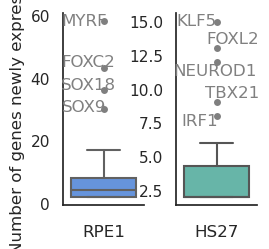

In [705]:
from adjustText import adjust_text
sns.set_context('paper', font_scale = 1)
# Plot settings
sns.set(style="white")
sns.set_palette('colorblind')

#plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'


# Assume df is your DataFrame from the previous example
df = pioneering_comb#.fillna(0) #pioneering_masked_active


df['cell_type'] = df['cell_type'].astype('category')
df['target_gene'] = df['target_gene'].astype('category')

value = 'on_mask_atac_min2' #which col to use for values

# Create an empty DataFrame to hold outliers
outliers_df = pd.DataFrame(columns=df.columns)

groups = ['RPE1', 'Hs27']


outliers_dfs = {}
# Calculate outliers for each group and append them to outliers_df
for group in ['RPE1', 'Hs27']:
    subset = df[df['cell_type'] == group]
    q1 = subset[value].quantile(0.25)
    q3 = subset[value].quantile(0.75)
    iqr = q3 - q1
    # Filtering outliers
    outlier_subset = subset[(subset[value] < (q1 - 1.5 * iqr)) | (subset[value] > (q3 + 1.5 * iqr))]
    
    outlier_subset['cell_type'] =  outlier_subset['cell_type'].cat.remove_unused_categories()
    outliers_dfs[group] = outlier_subset

RPE1_data = df[df['cell_type'] == 'RPE1']
RPE1_data['cell_type'] = RPE1_data['cell_type'].cat.remove_unused_categories()

fibro_data = df[df['cell_type'] == 'Hs27']
fibro_data['cell_type'] = fibro_data['cell_type'].cat.remove_unused_categories()

# Create a figure with two subplots with shared y-axes
fig, axes = plt.subplots(1, 2, figsize=(2.5, 2.5), sharey=False, gridspec_kw={'width_ratios': [1, 1]})

# Left plot for rpe1_a
sns.boxplot(x='cell_type', y=f'{value}', data=RPE1_data, ax=axes[0], color="#528FF0", showfliers=False)
sns.swarmplot(x='cell_type', y=f'{value}', data=outliers_dfs['RPE1'], 
              color='black', alpha=0.5, ax=axes[0])

# Right plot for fibro_a
sns.boxplot(x='cell_type', y=f'{value}', data=fibro_data, ax=axes[1], color="#5AC2B0", showfliers=False)
sns.swarmplot(x='cell_type', y=f'{value}', data=outliers_dfs['Hs27'], 
              color='black', alpha=0.5, ax=axes[1])


for ax, group in zip(axes, groups):
    outlier_subset = outliers_dfs[group]
    
    texts = []
    
    for index, row in outlier_subset.iterrows():
        # Add text annotation
        texts.append(ax.text(x=row['cell_type'], y=row[value], s=row['target_gene'], color='grey', ha='right'))

    # Adjust text to not overlap
    adjust_text(texts, ax=ax)  # Provide the axes to adjust_text if needed for better layout management

# Titles for each subplot
axes[0].set_xlabel('RPE1')
axes[1].set_xlabel('HS27')

# Set the labels (if you want to keep the y-label only on the left plot, adjust accordingly)
axes[0].set_ylabel('Number of genes newly expressed')
axes[1].set_ylabel('')

# Set the x-tick labels to empty since they are not meaningful in this context
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

# Adjust the subplot parameters to give some space between the plots
plt.subplots_adjust(wspace=0.4)

# Use despine to remove the right and top borders
sns.despine()


plt.savefig(f'/data/norman/southark/tfs_standardized/figure_exports/newly_expressed_genes_boxplots_{value}.svg')

# Show the plot
plt.show()

22
5


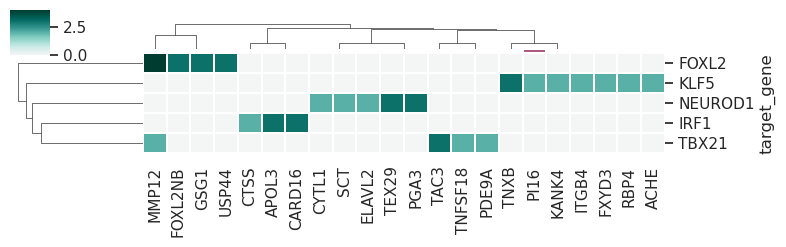

In [706]:
target_matrix = genes_activated_df['fibro_a'][value]

num_guides_on = 1 #filter for min num of guides that gene in on in
num_genes_activated = 3
num_targets_gene_on = 1

filtered_targets = target_matrix.loc[outliers_dfs['Hs27'].target_gene]
#filtered_targets = target_matrix.loc[target_matrix[target_matrix >= num_guides_on].sum(axis = 1) > num_genes_activated ]



#filter columns
filtered_genes = filtered_targets.columns[(filtered_targets >= num_guides_on).sum() >= num_targets_gene_on]

genes_of_interest = ['PDGFB',
                     #'PDGFR',
                     #'PPARG', 
                     'POSTN', #high expression in Lrrc15+ cluster
                     'PI16', #universal marker
                     #defined steady state markers
                     'COMP', #
                     'CCL19',
                     'COCH',
                     'CXCL12',
                     'FBLN1',
                     'BMP4',
                     'NPNT',
                     'HHIP'
                     #universal Dpt+Col15a1+
                     'DPT',
                     'COL15A1',
                     'C3'
                     'CXCL12', 
                     'SMOC2', 
                     'C7',
                     'FBLN5',
                     'MFAP4',
                     'LUM',
                     'FMO2',
                     #universal Dpt+Pi16+
                     'IGFBP5', 
                     'IGFBP6', 
                     'C3', 
                     'APOD'
                     #named clusters Korsunsky 2022
                     'CD34',
                     'MFAP5',
                     'CXCL10',
                     'CCL19',
                     'FBLN1',
                     'MYH11',
                     'PTGS2',
                     'SEMA4A',
                     'SPARC',
                     'COL3A1'
                    ]

# Your existing code for filtering
# ...

# Create a color label for each gene in 'filtered_genes'
col_colors = filtered_genes.map(lambda x: "#AE5981" if x == 'PI16' or x == 'CD34' else '#D99828' if x in genes_of_interest else 'white')#.tolist()
#col_colors = filtered_genes.map(lambda x: '#D99828' if x in genes_of_interest else 'white').tolist()



print(len(filtered_genes))
print(len(filtered_targets.index))

sns.clustermap(filtered_targets[filtered_genes], linewidths=0.01,linecolor='white',
               figsize = (8,2.5), cmap = 'BrBG', center = 0, #BrBG
               vmax = 4, robust = True,
              col_colors=col_colors)

plt.savefig(f'/data/norman/southark/tfs_standardized/figure_exports/20240417_newly_expressed_genes_heatmap_{value}_wide.svg')


62
4


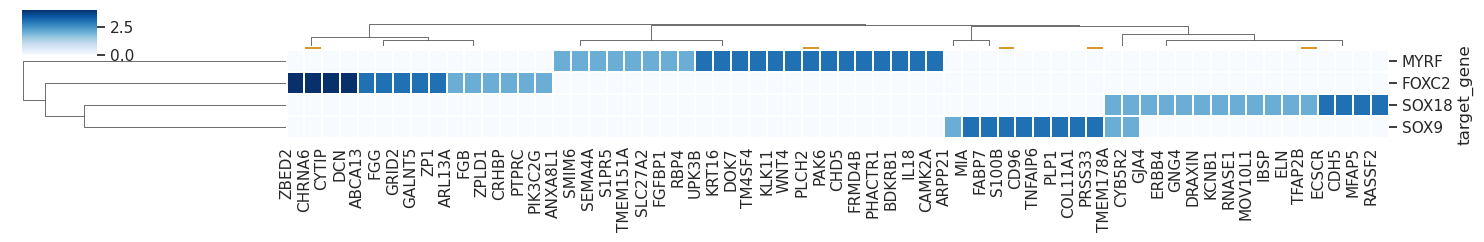

In [707]:
target_matrix = genes_activated_df['rpe1_a'][value]

num_guides_on = 1 #filter for min num of guides that gene in on in
num_genes_activated = 3
num_targets_gene_on = 1

filtered_targets = target_matrix.loc[outliers_dfs['RPE1'].target_gene]
#filtered_targets = target_matrix.loc[target_matrix[target_matrix >= num_guides_on].sum(axis = 1) > num_genes_activated ]

genes_of_interest = retina_markers.tolist()+additional_rpe+additional_other


#filter columns
filtered_genes = filtered_targets.columns[(filtered_targets >= num_guides_on).sum() >= num_targets_gene_on]

gene_of_interest = []#fill
# Your existing code for filtering
# ...

# Create a color label for each gene in 'filtered_genes'
col_colors = filtered_genes.map(lambda x: "#AE5981" if x == 'PI16' or x == 'CD34' else '#D99828' if x in genes_of_interest else 'white')#.tolist()
#col_colors = filtered_genes.map(lambda x: '#D99828' if x in genes_of_interest else 'white').tolist()



print(len(filtered_genes))
print(len(filtered_targets.index))

g = sns.clustermap(filtered_targets[filtered_genes], linewidths=0.01,linecolor='white',
               figsize = (15,2.5), cmap = 'Blues',# center = 0, #BrBG
               vmax = 4, robust = True,
              col_colors=col_colors)

# Get the order of the columns from the clustermap's result
clustered_cols = g.data2d.columns.tolist()

num_columns = filtered_targets[filtered_genes].shape[1]
g.ax_heatmap.set_xticks(range(num_columns))


# Apply the labels in the clustered order
g.ax_heatmap.set_xticklabels(clustered_cols, rotation=90)

# Rotate x-axis labels for clarity
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
g.ax_heatmap.xaxis.set_tick_params(pad=0)  # Adjust spacing if needed

plt.savefig(f'/data/norman/southark/tfs_standardized/figure_exports/20240417_rpe1_newly_expressed_genes_heatmap_{value}_wide.svg')


# Full lists of genes turned on per guide
no per target collapsing

In [85]:
#import regresssions results for annotations

gwps_mean_pop = CellPopulation.from_hdf('/data/norman/southark/tfs_standardized/20240311_fibroblast_CRISPRa_mean_pop.hdf', stored_matrix_ids=['p', 'adj_p', 'masked'])
gwps_mean_pop.genes.index.name = 'gene_id'

Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix', '/normalized_matrix_adj_p', '/normalized_matrix_masked', '/normalized_matrix_p']
Loading metadata...
Done in 5.558412551879883s.
Done.


In [86]:
expanded_guides = pd.read_csv('/data/norman/southark/tfs_standardized/20240319_rescued_fibroblast_guides.csv', index_col=0)
gwps_mean_pop.cells['expanded_masked_active'] = expanded_guides['expanded_masked_active']



In [87]:
guide_library = pd.read_csv('/data/norman/southark/tfs_standardized/20240318_merged_morf_tf_lib_guide_activity_classifications_final_low_UMI_count_regressions_coef.csv', index_col=0)


guide_library['masked_active'] = gwps_mean_pop.cells['masked_active']
guide_library['expanded_masked_active'] = gwps_mean_pop.cells['expanded_masked_active']
guide_library['masked_active'].fillna(False, inplace=True)
guide_library['expanded_masked_active'].fillna(False, inplace=True)
guide_library['de_genes'] = gwps_mean_pop.cells['de_genes']

masked_and_strongest = guide_library.query('masked_active and not bad_seed').sort_values('de_genes', ascending=False).groupby('target_gene').head(1).index
expanded_masked = guide_library.query('expanded_masked_active and not bad_seed').index


gwps_mean_pop.cells['primary_guide'] = gwps_mean_pop.cells.index.isin(masked_and_strongest)
gwps_mean_pop.cells['expanded_primary_guide'] = gwps_mean_pop.cells.index.isin(np.union1d(masked_and_strongest, expanded_masked))

In [88]:
def guide_specific_activation_counts(analysis_result,pop_filter = 'good_guide == True', min_activation_count=1, activation_mask="on_mask"):
    cell_pop = analysis_result
    good_guides = cell_pop.cells.query(pop_filter)
    
    sig_up_genes = cell_pop.normalized_matrix[activation_mask]
    
    guide_to_genes_activated = {}
    guide_to_activation_counts = {}  # Stores counts of genes activated by each guide
    
    for index, row in good_guides.iterrows():
        guide_id = index  # Assuming each guide has a unique identifier in your data
        target_gene = row['target_gene']
        
        TARGET_indices = [index]  # Now working with individual guides, not targets
        turned_on_counts = sig_up_genes.loc[TARGET_indices].sum()
        
        # Excluding the target gene
        gene_id = cell_pop.genes.query('gene_name == @target_gene').index
        activated_genes = turned_on_counts[turned_on_counts > min_activation_count].index.difference(gene_id)
        
        # Storing gene names instead of IDs, assuming 'gene_name' is the column with gene names
        guide_to_genes_activated[guide_id] = cell_pop.genes.loc[activated_genes, 'gene_name'].tolist()

        # Populate guide_to_activation_counts with actual counts for all activated genes, still excluding the target gene
        for gene in activated_genes:
            gene_name = cell_pop.genes.loc[gene, 'gene_name']
            guide_to_activation_counts.setdefault(guide_id, {})[gene_name] = turned_on_counts[gene]
        
    # Creating DataFrame for a more structured representation, if necessary
    activation_counts_df = pd.DataFrame.from_dict(guide_to_activation_counts, orient='index').fillna(0)
    activation_counts_df.index.name = 'guide_id'
    
    return guide_to_genes_activated, activation_counts_df


In [89]:
pioneering_activation_dict = {}
pioneering_activation_df = {}


for name, pop in  analysis_results_dict.items():
        guide_to_genes_activated, guide_activation_counts_df= guide_specific_activation_counts(
                                                        pop, 
                                                        pop_filter = 'is_activated == True',
                                                        min_activation_count=0, 
                                                        activation_mask="on_mask_atac")
        pioneering_activation_dict[name] = guide_to_genes_activated
        pioneering_activation_df[name] = guide_activation_counts_df
        
          # Calculate the count of activated genes for each guide
        guide_to_num_genes_activated = {guide_id: len(genes) for guide_id, genes in guide_to_genes_activated.items()}
    
        # Assign the counts to 'num_genes_on_atac_masked' in pop.cells
        pop.cells['num_genes_on_atac_masked'] = pop.cells.index.map(guide_to_num_genes_activated).fillna(0)
        
        pop.cells['activated_genes_atac'] = pop.cells.index.map(guide_to_genes_activated)
        

In [90]:
pioneering_activation_dict['fibro_a']['KLF4_GCTCCCTTCCATCGTTGCTA']

['TNXB']

In [349]:
#resulting df is a binary of the gene activation, 
#redundant with the masked matrix bool, except removed targets and filtered for good guides
pioneering_activation_df['fibro_a']['DPT'].sort_values()

guide_id
AATF_GCGCAGAAGGTTGAAGGGAT       0.0
RFX6_GCAGAAAGGACGCCGCGCAC       0.0
SKIL_GAAGGGAACGGAGCCAGCGG       0.0
TCF21_GAGCCACCTTCTCCCAACTG      0.0
TLX2_GGACTCAGCGGCCCATGCTC       0.0
                               ... 
ASCL1_GGCAAACTCTCCATTCAGCT      0.0
DENND4A_GTAGCGCCAAACTGATAATG    0.0
HES2_GCCACCCTGCGCAGGAACAA       0.0
FOXP4_GACTGAGCCTGGGCTGCGAG      0.0
BATF2_GACCAGCTGCTCAGAATCCC      1.0
Name: DPT, Length: 2565, dtype: float64

In [92]:
gene_activation_dict = {}
gene_activation_df = {}


for name, pop in  analysis_results_dict.items():
        guide_to_genes_activated, guide_activation_counts_df= guide_specific_activation_counts(
                                                        pop,
                                                        pop_filter = 'is_activated == True',
                                                        min_activation_count=0, 
                                                        activation_mask="on_mask")
        gene_activation_dict[name] = guide_to_genes_activated
        gene_activation_df[name] = guide_activation_counts_df
        
                  # Calculate the count of activated genes for each guide
        guide_to_num_genes_activated = {guide_id: len(genes) for guide_id, genes in guide_to_genes_activated.items()}
    
        # Assign the counts to 'num_genes_on_atac_masked' in pop.cells
        pop.cells['num_genes_on_masked'] = pop.cells.index.map(guide_to_num_genes_activated).fillna(0)

        pop.cells['activated_genes_all'] = pop.cells.index.map(guide_to_genes_activated)
        

In [ ]:
gene_activation_df['fibro_a']['DPT'].sort_values()

# Pioneering Enrichr

In [618]:
def calculate_percentile_threshold(series, percentile):
    """
    Calculate the threshold for a given percentile in a Pandas Series.
    
    Parameters:
    - series: Pandas Series containing numerical data.
    - percentile: float, the percentile to calculate the threshold for (between 0 and 100).
    
    Returns:
    - float, the threshold value at the specified percentile.
    """
    if not isinstance(series, pd.Series):
        raise ValueError("Input must be a Pandas Series.")
    if not 0 <= percentile <= 100:
        raise ValueError("Percentile must be between 0 and 100.")
    
    threshold = series.quantile(percentile / 100)
    return threshold



# Sample data series

rpe1_atac_counts =pctl_pops['rpe1_a'].cells[pctl_pops['rpe1_a'].cells.is_activated.fillna(False)|pctl_pops['rpe1_a'].cells.masked_active].num_genes_on_atac_masked

fibro_atac_counts = pctl_pops['fibro_a'].cells[pctl_pops['fibro_a'].cells.is_activated.fillna(False)|pctl_pops['fibro_a'].cells.masked_active].num_genes_on_atac_masked

percentile = 80


rpe1_atac_threshold = calculate_percentile_threshold(rpe1_atac_counts, percentile)
fibro_atac_threshold = calculate_percentile_threshold(fibro_atac_counts, percentile)


print(f"The {percentile}th percentile threshold for rpe1_atac is: {rpe1_atac_threshold}")
print(f"The {percentile}th percentile threshold for fibro_atac is: {fibro_atac_threshold}")

guides_active= guide_library[(guide_library.is_activated_rpe1)|(guide_library.masked_active_rpe1)
                            |(guide_library.is_activated_fibro)|(guide_library.masked_active_fibro)
                                & ~(guide_library.bad_seed|guide_library.seed_driven_rpe1|guide_library.seed_driven_fibro)]

guides_active["num_genes_on_atac_f"] = fibro_atac_counts
guides_active["num_genes_on_atac_r"] = rpe1_atac_counts

guides_active['pioneering_in_both'] = (guides_active.num_genes_on_atac_f > fibro_atac_threshold ) & (guides_active.num_genes_on_atac_r > rpe1_atac_threshold )

The 80th percentile threshold for rpe1_atac is: 4.0
The 80th percentile threshold for fibro_atac is: 2.0


/tmp/ipykernel_372000/3100439734.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guides_active["num_genes_on_atac_f"] = fibro_atac_counts
/tmp/ipykernel_372000/3100439734.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guides_active["num_genes_on_atac_r"] = rpe1_atac_counts
/tmp/ipykernel_372000/3100439734.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [619]:
grouped_active = guides_active.groupby("target_gene").agg({
                                                             'num_genes_on_atac_f': ['min', 'max','mean', 
                                                                                'std', 'count',
                                                                                lambda x: (x > fibro_atac_threshold).sum()], #must have at least 2 genes (atac)
                                                            'num_genes_on_atac_r': ['min', 'max','mean', 
                                                                                'std', 'count',
                                                                                lambda x: (x > rpe1_atac_threshold).sum()], #must have at least 2 genes (atac)                                                           
                                                            'pioneering_in_both': ['sum'],
                                                            })


grouped_active.columns = ['_'.join(col).strip() for col in grouped_active.columns.values]


grouped_active = grouped_active.rename(columns = {
                                                 'num_genes_on_atac_f_<lambda_0>': 'num_guides_atac_fibro',
                                 'num_genes_on_atac_r_<lambda_0>': 'num_guides_atac_rpe1'})


grouped_active['prop_pioneering_fibro'] =  grouped_active.num_guides_atac_fibro /grouped_active.num_genes_on_atac_f_count
grouped_active['prop_pioneering_rpe1'] =  grouped_active.num_guides_atac_rpe1 /grouped_active.num_genes_on_atac_r_count

In [622]:
pioneering_in_both = grouped_active[(grouped_active.pioneering_in_both_sum >= 1)].index
pioneering_in_either = grouped_active[(grouped_active.num_guides_atac_fibro > 1)|(grouped_active.num_guides_atac_rpe1 > 1)].index

background_activateable =guides_merged[(guides_merged.is_activated_fibro|guides_merged.masked_active_fibro)|(guides_merged.is_activated_rpe1|guides_merged.masked_active_rpe1)].target_gene.unique()
background_activateable_both =guides_merged[(guides_merged.is_activated_fibro|guides_merged.masked_active_fibro)&(guides_merged.is_activated_rpe1|guides_merged.masked_active_rpe1)].target_gene.unique()

In [623]:
pioneering_in_both

Index(['AHRR', 'ALX1', 'ALX4', 'ATF3', 'BBX', 'BHLHE40', 'BSX', 'CDX2',
       'CEBPB', 'CERS4',
       ...
       'ZMYND11', 'ZNF114', 'ZNF160', 'ZNF219', 'ZNF324B', 'ZNF442', 'ZNF467',
       'ZNF488', 'ZNF518B', 'ZNF821'],
      dtype='object', name='target_gene', length=147)

In [710]:
gp.__version__

'1.1.1'

In [625]:
len(background_activateable)

1493

2024-04-17 16:21:35,537 [INFO] User defined gene sets is given: /data/norman/southark/gene_sets/gmt/PPI/PPI_Hub_Proteins.gmt
2024-04-17 16:21:35,585 [INFO] User defined gene sets is given: /data/norman/southark/gene_sets/gmt/PPI/Transcription_Factor_PPIs.gmt
2024-04-17 16:21:35,619 [INFO] Run: PPI_Hub_Proteins.gmt 
2024-04-17 16:21:35,729 [INFO] Run: Transcription_Factor_PPIs.gmt 
2024-04-17 16:21:35,820 [INFO] Done.


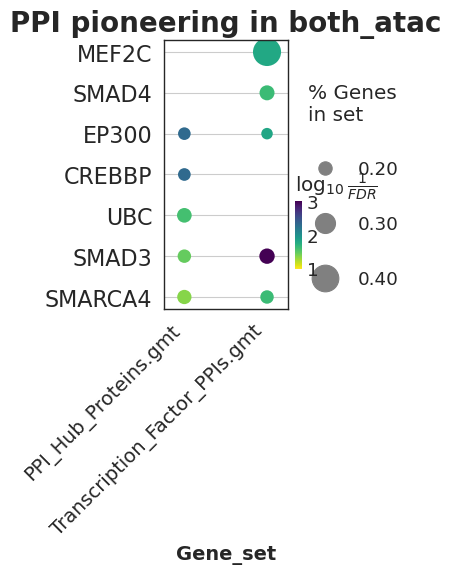

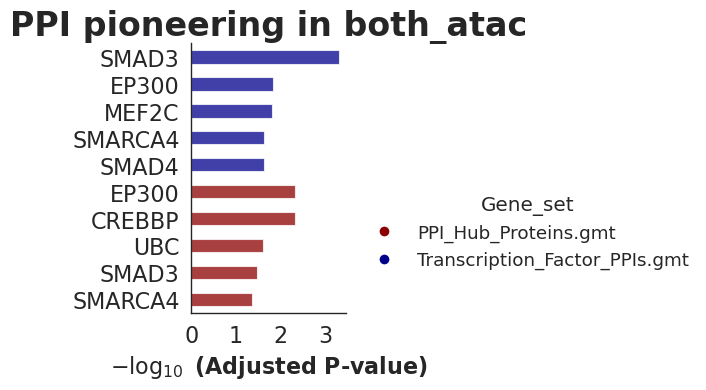

In [637]:
enr2 = gp.enrich(gene_list=pioneering_in_both.tolist(),
                 #gene_list=pioneering_in_either.tolist(),
                 gene_sets=["/data/norman/southark/gene_sets/gmt/PPI/PPI_Hub_Proteins.gmt",
                            '/data/norman/southark/gene_sets/gmt/PPI/Transcription_Factor_PPIs.gmt',
                           ],
                 background=background_activateable.tolist(),
                 #outdir=enrichr_results_dir,
                 verbose=True)


ax = dotplot(enr2.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
             cutoff = 0.05,
              figsize=(2,3.5),
              title = "PPI pioneering in both_atac",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=False, # set to False to revmove outer ring
              marker='o',
             )

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240419_pioneering_enrichr.pdf')


ax = barplot(enr2.results,
              column="Adjusted P-value",
              group='Gene_set', # set group, so you could do a multi-sample/library comparsion
              size=10,
             cutoff = 0.05,
              top_term=5,
             title = "PPI pioneering in both_atac",
              figsize=(2,3.5),
              color=['darkred', 'darkblue', 'gold', 'darkgreen'] # set colors for group
             )

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240419_pioneering_enrichr_barplot.pdf')


In [639]:
enr2.results.sort_values('Adjusted P-value')

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
423,Transcription_Factor_PPIs.gmt,SMAD3,30/130,0.000002,0.000506,3.219498,41.810658,SOX9;NR3C1;SMARCA4;PRDM16;CTNNB1;RELA;SMAD6;CE...
62,PPI_Hub_Proteins.gmt,EP300,35/185,0.000037,0.004801,2.508719,25.585733,SOX9;NR3C1;CTNNB1;CREB3L1;RELA;CEBPB;ALX1;ZBTB...
45,PPI_Hub_Proteins.gmt,CREBBP,35/184,0.000033,0.004801,2.527611,26.093627,SPIB;SOX9;NFE2L2;NR3C1;SMARCA4;CTNNB1;CREB3L1;...
298,Transcription_Factor_PPIs.gmt,EP300,38/220,0.000137,0.015187,2.243485,19.949881,SOX9;NR3C1;CTNNB1;CREB3L1;RELA;CEBPB;ALX1;ZBTB...
358,Transcription_Factor_PPIs.gmt,MEF2C,8/19,0.000216,0.015924,7.076048,59.718354,NOTCH1;NCOA2;EPAS1;GATA4;SMAD2;TFCP2;SOX18;MYOD1
...,...,...,...,...,...,...,...,...
367,Transcription_Factor_PPIs.gmt,NANOG,2/39,0.910572,0.918887,0.600000,0.056210,SMARCA4;RELA
246,PPI_Hub_Proteins.gmt,VHL,1/26,0.934057,0.937692,0.530616,0.036197,EPAS1
66,PPI_Hub_Proteins.gmt,EWSR1,1/30,0.956794,0.956794,0.457280,0.020197,SUZ12
272,Transcription_Factor_PPIs.gmt,CCND1,1/31,0.961135,0.961135,0.441952,0.017519,CTNNB1


# Side by side MARKER Mean Coefs and Newly Turned on Genes


MARKER genes

# START With Clustering Guides for Newly Expressed Genes

In [93]:
#Start with filter to targets that turn on genes and cluster
#actually going to start doing this on guides, and then maybe collapse to targets later

In [172]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, leaves_list
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase 


def filter_and_prepare_data(cell_population, good_guide_condition = True, num_genes_on =2, genes_on_col ='num_genes_on_masked' , mask = 'on_mask_atac'):
    # Filter data based on conditions
    filtered_data = cell_population.where(f'(good_guide == {good_guide_condition})&({genes_on_col} >= {num_genes_on})',
                                          genes=f'num_guides_sig_up >= 2', normalized=True, normalized_name=mask)
    
    # Drop columns where no values are True
    filtered_data = filtered_data.loc[:, filtered_data.any(axis=0)]
    
    return filtered_data.fillna(False)

def filter_and_prepare_data_from_df(cell_population, df, good_guide_condition = True, num_genes_on =2, genes_on_col ='num_genes_on_masked'):
    # Filter data based on conditions
    filtered_guides = cell_population.cells.query(f'(good_guide == {good_guide_condition}) & ({genes_on_col} >= {num_genes_on})').index
    
    # Drop columns where no values not zero
    df= df.loc[df.index[df.index.isin(filtered_guides)]]
    df_filtered = df.loc[(df != 0).any(axis=1), (df != 0).any(axis=0)]
    
    return df_filtered.fillna(0)

def similarity_to_dataframe(similarity_matrix, index):
    similarity_df = pd.DataFrame(similarity_matrix, index=index, columns=index)
    return similarity_df

def calculate_similarity(data):
    data_bool = data.to_numpy(dtype=bool)
    dice_distance = pairwise_distances(data_bool, metric='dice')
    dice_similarity = 1 - dice_distance
    return similarity_to_dataframe(dice_similarity, index=data.index)

def find_high_similarity_pairs(similarity_df, threshold = 0.5):
    mask_high_similarity = (similarity_df >= threshold) & ~np.eye(similarity_df.shape[0], dtype=bool)
    high_similarity_pairs = np.where(np.triu(mask_high_similarity, 1))
    total_pairs = high_similarity_pairs[0].shape[0]  # Calculate the total number of pairs found

    print(f"Total number of pairs found at threshold {threshold}: {total_pairs}")  # Print total number of pairs found

    pair_count = 0  # Initialize a counter for the number of pairs printed

    for i, j in zip(*high_similarity_pairs):
        if pair_count < 20:  # Print details of pairs if less than 50 have been printed
            print(f"Pair with high similarity: {similarity_df.index[i]} and {similarity_df.index[j]}, Similarity: {similarity_df.iloc[i, j]}")
        pair_count += 1  # Increment the counter each time a pair is processed
        
    if pair_count > 20:  # Check if more than 50 pairs have been found
        print("More than 50 pairs found. Printing limited to first 50 pairs.")

def hierarchical_clustering_and_plot(similarity_df, method='average', plot_dendrogram=False):
    distance_matrix = 1 - similarity_df.to_numpy()

    # Check for non-finite values and diagnose the issue
    if not np.isfinite(distance_matrix).all():
        print("Non-finite values found in the distance matrix.")

        # Optional: Handling non-finite values
        # For example, set any NaN values to a high distance (e.g., 1) to indicate dissimilarity
        distance_matrix = np.nan_to_num(distance_matrix, nan=1.0)

        # Ensure diagonal is 0 for self-similarity
        np.fill_diagonal(distance_matrix, 0)

    # Proceed with hierarchical clustering
    Z = linkage(distance_matrix, method='average')

    
    if plot_dendrogram:
        plt.figure(figsize=(100, 7))
        dendrogram(Z, labels=similarity_df.index)
        plt.title("Hierarchical Clustering Dendrogram")
        plt.xlabel("Cells")
        plt.ylabel("Distance")
        plt.show()
        
    
    # Get the order of rows as per the hierarchical clustering
    row_order = leaves_list(Z)

    # Convert indices to original DataFrame index labels if needed
    row_labels_order = similarity_df.index[row_order]

    return Z, row_labels_order

def form_clusters(Z, similarity_df, distance_threshold, min_members=2):
    clusters = fcluster(Z, distance_threshold, criterion='distance')
    
    # Initialize an empty dictionary to hold cluster groups
    cluster_groups = {}

    # Map columns to their respective clusters
    for i, cluster_id in enumerate(clusters):
        cluster_groups.setdefault(cluster_id, []).append(similarity_df.columns[i])

    # Identify clusters with a minimum number of members as specified by min_members
    filtered_clusters = {cluster_id: members for cluster_id, members in cluster_groups.items() if len(members) >= min_members}

    # Optionally, print out the filtered clusters
    
    for cluster_id, members in filtered_clusters.items():
        print(f"Cluster {cluster_id} with {min_members} or more members: {members}")

    # Return the dictionary of filtered clusters
    return filtered_clusters


def perform_analysis_and_plot(analysis_result, activation_df, key, num_activated_genes = 4,
                              num_activated_col = 'num_genes_on_masked', num_guides_activating = 1, 
                              dist_thres=1.2, cluster_members=2,activation_mask = 'on_mask_atac'):
    
    #filtering for strongly activating guides
    filtered_data = filter_and_prepare_data_from_df(analysis_result[key], 
                                            activation_df[key], 
                                            num_genes_on=num_activated_genes,
                                            genes_on_col=num_activated_col)
    
    similarity_df = calculate_similarity(filtered_data)
    Z, row_labels_order = hierarchical_clustering_and_plot(similarity_df)
    
    clusters_with_2_or_more_members = form_clusters(Z, similarity_df, distance_threshold =dist_thres,min_members = cluster_members)
    
    members_to_include = [member for members in clusters_with_2_or_more_members.values() for member in members]
    members_to_include_active = [x for x in members_to_include if x in analysis_result[key].cells[analysis_result[key].cells.masked_active == True].index]

    active_cells = members_to_include_active 

    # Perform initial filtering to get columns with sum greater desired_counts
    columns_with_activity = analysis_result[key].where(
        cells=active_cells, 
        normalized=True, 
        normalized_name=activation_mask
    ).sum().loc[lambda x: x >= num_guides_activating].index.tolist()

    # Assuming 'where' with 'gene_names=True' returns a DataFrame with relevant gene expression data
    expr = analysis_result[key].where(
        cells=active_cells, 
        genes=columns_with_activity, 
        normalized=True, 
        normalized_name='pctl_expr', 
        gene_names=True
    ).fillna(0)

    # Apply additional conditions (significance and count) to expr
    expr_filtered = expr * (analysis_result[key].where(
        cells=active_cells, 
        genes=columns_with_activity, 
        normalized=True, 
        normalized_name='adj_p', 
        gene_names=True) < 0.01)
    
#     expr_filtered *= (analysis_result[key].where(
#         cells=active_cells, 
#         genes=columns_with_activity, 
#         normalized=True, 
#         normalized_name='pctl_expr', 
#         gene_names=True) > 30)

    expr_filtered *= (analysis_result[key].where(
        cells=active_cells, 
        genes=columns_with_activity, 
        normalized=True, 
        normalized_name='count_profile', 
        gene_names=True) >= 3)

    # Further filter columns in expr_filtered with non-zero sums
    columns_final = expr_filtered.sum().loc[lambda x: x > 0].index.tolist()
    rows_final = expr_filtered.sum(axis = 1).loc[lambda x: x > 0].index.tolist()
    expr_final = expr_filtered.loc[rows_final,columns_final]

    # Largest Context:
    sns.set_context("paper")

    # Filter the similarity DataFrame for these members
    filtered_similarity_df = similarity_df.loc[members_to_include_active, members_to_include_active]
    g = sns.clustermap(filtered_similarity_df.loc[rows_final, rows_final], method='ward', figsize=(15, 15), 
                       cmap="RdBu_r", center = 0)

    # Adjust plot aesthetics
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
    
    # Extract row and column order from the original clustermap
    row_order = g.dendrogram_row.reordered_ind
    col_order = g.dendrogram_col.reordered_ind
    
    row_index_order = expr_final.iloc[row_order, :].index

    g_expr = sns.clustermap(expr_final.iloc[row_order, :], method='ward',
                            figsize=(20, 14), cmap='RdBu_r', center = 0, #vmin=0, 
                            row_cluster=False, col_cluster=True)

    plt.show()

    return row_index_order

In [173]:
# rows_final_fibro = perform_analysis_and_plot(analysis_results_dict,pioneering_activation_df, 
#                           key = 'fibro_a', num_activated_genes = 2, 
#                           num_activated_col = 'num_genes_on_atac_masked',
#                           num_guides_activating = 2,
#                               dist_thres=1.3, cluster_members=2,
#                              activation_mask = 'on_mask')

In [1]:
blood_and_immune_cells = {
            'B-cells' : ['CD19','CR2','MS4A1'],
            'Dendritic cells' : ['GZMB','IL3RA'],
            'Granulocytes' : ['CEBPE','HDC','MS4A2'],
            'Macrophages' : ['CD163','CD68','MARCO','MRC1','MSR1'],
            'Monocytes': ['FCGR3A'],
            'NK-cells' : ['KIR2DL4'],
            'Plasma cells': ['PIM2'],
            'T-cells': ['CD3E','CD4','CD8A','FOXP3','IL17A'],
            #skin
            'Langerhans cells': ['CD1A','CD207', 'CD68']
}

endothelial_cells = {
            'Endothelial cells' : ['CD34','PECAM1','SELE','SLC2A1','VWF'],
            'Lymphatic endothelial cells': ['FLT4','LYVE1']
}

glial_cells = {  #eye set
            'Muller glia cells' : ['APOE', 'CLU','GLUL'],
            'Schwann cells' : ['MBP','MPZ', 'S100B','SOX10'],
            #brain set
            'Astrocytes': ['ALDH1L1','GFAP', 'SLC1A3', 'NG2'],
            'Microglial cells' :['AIF1','ITGAM', 'P2RY12','TYROBP'],
            'Oligodendrocyte precursor cells' : ['GPR17'],
            'Oligodentrocytes': ['MBP','MOG']
}
     
mesenchymal_cells = {
            'Fibroblasts' : ['COL3A1','FBN1', 'LUM'],
            'Endometrial stromal cells': ['GJA1','MME','ZEB1'],
            'Ovarian stromal cells': [] #none listed
}
    
muscle_cells = {
            'Smooth muscle cells' : ['ACTA2', 'ACTG2', 'CNN1', 'MYH11'],
            'Cardiomyocytes': ['MYH7','MYL2', 'MYL7', 'TTN'],
            'Skeletal myocytes': ['MB', 'MYH2', 'MYL2']
}

neuronal_cells = {#eye set
            'Bipolar cells' : ['CAMK2B','GRM6','TRPM1'],
            'Cone photoreceptor cells' : ['GNAT2','OPN1LW','OPN1MW'],
            'Horizontal cells' : ['LHX1','ONECUT1','ONECUT2'],
            'Rod photoreceptor cells' : ['NR2E3','PDE6A','SAG'],
            #brain set
            'Excitatory neurons': ['CUX2', 'NRGN', 'SLC17A7', 'TBR1'],
            'Inibitory neurons': ['GAD1', 'PVALB', 'SLC32A1', 'SST', 'VIP']
}

pigment_cells = {
             'Melanocytes' : ['DCT','MLANA','TYRP1']
}

squamous_epithelial_cells = {
            'Basal keratinocytes' : ['COL17A1','KRT14','KRT5'],
            'Suprabasal keratinocytes' : ['KRT1','KRT10','KRTDAP'],
            'Basal squamous epithelial cells': ['COL17A1','KRT15'],
            'Squamous epithelial cells': ['ADH7','CRNN','KRT6A']
}

glandular_epithelial_cells = {
    "Ciliated cells": [],
    "Basal respiratory cells": [],
    "Club cells": [],
    "Ionocytes": [],
    "Mucus glandular cells": [],
    "Serous glandular cells": [],
    "Gastric mucus-secreting cells": [],
    "Proximal enterocytes": [],
    "Paneth cells": [],
    "Distal enterocytes": [],
    "Intestinal goblet cells": [],
    "Exocrine glandular cells": [],
    "Basal prostatic cells": [],
    "Prostatic glandular cells": [],
    "Breast glandular cells": [],
    "Breast myoepithelial cells": [],
    "Glandular and luminal cells": [],
    "Secretory cells": [],
    "Any glandular epithelial cells": []
}

specialized_epithelial_cells = {
"Alveolar cells type 1": [],
    "Alveolar cells type 2": [],
    "Salivary duct cells": [],
    "Ductal cells": [],
    "Hepatocytes": [],
    "Cholangiocytes": [],
    "Proximal tubular cells": [],
    "Distal tubular cells": [],
    "Collecting duct cells": [],
    "Mesothelial cells": [],
    "Sertoli cells": [],
    "Granulosa cells": []}

undifferentiated_cells = {'undifferentiated' : []}

In [178]:
#currated from HPA tissue and other sources

eye_cells = {'Retinal Pigmented Epithelial' : ['RLBP1', 'BCO2', 'SLC16A8', 'KRT18', 'KRT8', 'MITF', 'RPE65','MERTK','SERPINF1', 'TYR', 'RBP1'],#epithelial
             'Muller glia cells' : ['APOE', 'CLU','GLUL', 'RBP1', 'GFAP', 'RLBP1', 'AQP4', 'RLPB1', 'VIM', 'KCNJ10', 'S100B', 'GPR37L110', 'TXNIP'], #glial
             'Rod photoreceptor cells' : ['RHO', 'GNGT1', 'PDE6G','GNAT1' 'SAG','NR2E3','PDE6A', 'PDC', 'SAMD7', 'SMIM40', 'PPEF2', 'ANO2'],
             'Photoceptors' : ['CRX', 'OPN1MW3', 'AIPL1', 'RDH12', 'ABCA4'],
             'Cone photoreceptor cells' : ['GNGT2', 'GUCA1B', 'ARR3', 'GNAT2','OPN1LW','OPN1MW', 'CPLX4'],
             'Bipolar cells' : ['TRPM1', 'GNG13', 'CAMK2B','GRM6'],
             'Horizontal cells' : ['LHX1','ONECUT1','ONECUT2', 'PAX6'],
             'OLM' : ['CRB2', 'TMEM221'],
             'INL' : ['VSX2', 'RCVRN', 'CABP5'],
             'OPL_IPL' : ['ANO2', 'CPLX4', 'GRM6'],
             'Neuroglial' : ['GFAP', 'NG2'],
             'Neuronal' :['FOXA2', 'PAX6', 'TUJ1', 'NURR1', 'OTX2', 'TUBB3', 'RHO', 'REC', 'NES'],
             'Midbrain dopaminergic neuron' : ['SLC6A3', 'SLC18A2', 'TH', 'KCNJ6'],
             'Early photoreceptor differentiation' :['SIX6', 'PAX6', 'OTX2', 'RAX', 'NRL'],
}


retina_process = {
             'Extracellular Structure Organization' : ['CST3', 'EFEMP1', 'ITGAV', 'CRISPLD1', 'ITGB8'],
             'Visual cycle' : ['RPE65', 'BEST1', 'RBP1', 'RLBP1', 'RGR', 'LRAT', 'RDH5', 'RDH12'],
             'Phagocytosis' : ['GULP1', 'MERTK'],
             'Secretion' : ['SERPINF1','SERPINF1', 'VEGFA', 'ENPP2'],
             'Lipid Biosynthesis' : ['PTGDS'],
             'Melanin Biosynthesis' :['TRP1', 'TRP2', 'TYR', 'TYRP1', 'DCT', 'OCA2']
}

In [183]:
pctl_pops['fibro_a'].genes['ctrl_pctl'] = pctl_pops['fibro_a'].normalized_matrix['pctl_expr'].loc['control'].drop('control')
pctl_pops['fibro_a'].genes['control_expressed'] = pctl_pops['fibro_a'].genes['ctrl_pctl'] >= 15

pctl_pops['rpe1_a'].genes['ctrl_pctl'] = pctl_pops['rpe1_a'].normalized_matrix['pctl_expr'].loc['control'].drop('control')
pctl_pops['rpe1_a'].genes['control_expressed'] = pctl_pops['rpe1_a'].genes['ctrl_pctl'] >= 15

In [184]:
def filter_all_zero(df, axis=1):
    """Removes rows or columns where all values are equivalent to zero, based on the specified axis."""
    if axis == 1:  # columns
        return df.loc[:, df.abs().any(axis=0)]
    else:  # rows
        return df.loc[df.abs().any(axis=1), :]

def filter_small_change(df, min_change=-0.25, max_change=0.25, axis=1):
    """Filters out rows or columns where all values fall within a specified change range, based on the specified axis."""
    if axis == 1:  # columns
        filter_mask = df.apply(lambda x: not (x.gt(min_change) & x.lt(max_change)).all(), axis=0)
    else:  # rows
        filter_mask = df.apply(lambda x: not (x.gt(min_change) & x.lt(max_change)).all(), axis=1)
    return df.loc[:, filter_mask] if axis == 1 else df.loc[filter_mask, :]



def marker_gene_expr_filter(pops, key, cells, marker_genes, normalized_matrix = None ,sig_filter=True, fdr=0.01, zero_filter=True, value_filter=True, min_change=-0.25, max_change=0.25, filter_rows=False):
    """
    Filters marker gene expressions based on significance, zero values, and value changes.
    
    Parameters:
    - pops: The populations dictionary containing gene expression data.
    - key: The key to select the specific population data.
    - cells: The cells to include in the analysis.
    - marker_genes: The list of marker genes to filter by.
    - sig_filter: Whether to filter based on significance (adjusted p-value).
    - fdr: The FDR threshold for significance filtering.
    - zero_filter: Whether to remove columns with all zero values.
    - value_filter: Whether to filter out columns based on value changes.
    - min_change: The minimum change threshold for value filtering.
    - max_change: The maximum change threshold for value filtering.
    
    Returns:
    - A filtered DataFrame based on the specified criteria.
    """
    
    # Extract marker coefficients
    if normalized_matrix ==  'pctl_expr':
        marker_coefs = pops[key].where(cells=cells, genes='gene_name in @gene_list', gene_list=marker_genes, normalized=True, normalized_name=normalized_matrix, gene_names=True)

        marker_on = pops[key].where(cells=cells, genes='gene_name in @gene_list', gene_list=marker_genes, normalized=True, normalized_name='on_mask', gene_names=True)
        marker_change = marker_coefs * marker_on
        
        marker_change = filter_all_zero(marker_change)#.fillna(0)
        
        if filter_rows:
            if zero_filter:
                marker_change = filter_all_zero(marker_change, axis=0)
            if value_filter:
                marker_change = filter_small_change(marker_change, min_change, max_change, axis=0)
        
        return marker_change
    
    elif normalized_matrix ==  'pctl_change':
        
        marker_coefs = pops[key].where(cells=cells, genes='gene_name in @gene_list', gene_list=marker_genes, normalized=True, normalized_name=normalized_matrix, gene_names=True)
    
    elif normalized_matrix != None:
        print('normalized matrix should be = "pctl_expr" or I have not yet implemented this filter')
    
    else:    
        marker_coefs = pops[key].where(cells=cells, genes='gene_name in @gene_list', gene_list=marker_genes, gene_names=True)
    
    # Apply significance filter
    if sig_filter:
        marker_adj_p = pops[key].where(cells=cells, genes='gene_name in @gene_list', gene_list=marker_genes, normalized=True, normalized_name='adj_p', gene_names=True)
        marker_change = marker_coefs * (marker_adj_p < fdr).fillna(1)
    else:
        marker_change = marker_coefs
    
    # Apply zero value filter
    if zero_filter:
        marker_change = filter_all_zero(marker_change)
    
    # Apply value change filter
    if value_filter:
        marker_change = filter_small_change(marker_change, min_change, max_change)
        
        
        # Optionally filter rows for zeros and small changes
    if filter_rows:
        if zero_filter:
            marker_change = filter_all_zero(marker_change, axis=0)
        if value_filter:
            marker_change = filter_small_change(marker_change, min_change, max_change, axis=0)
    
    
    return marker_change

In [185]:
pctl_pops['rpe1_a'].normalized_matrix['pctl_change'] = pctl_pops['rpe1_a'].normalized_matrix['pctl_expr'] - pctl_pops['rpe1_a'].normalized_matrix['pctl_expr'].loc['control']
pctl_pops['rpe1_a'].normalized_matrix['pctl_change'] = pctl_pops['rpe1_a'].normalized_matrix['pctl_change'] - pctl_pops['rpe1_a'].normalized_matrix['pctl_expr'].loc['control'] 

# Cross Dataset Gene Program Merge

In [299]:
prog_markers100 = pd.read_csv('/data/norman/southark/gene_sets/fibroblast_lit_sets/human_cross_dataset_merge100.csv')
prog_markers20 = pd.read_csv('/data/norman/southark/gene_sets/fibroblast_lit_sets/human_cross_dataset_merge20.csv')

fibro_markers_rudensky =['CD34', 'MFAP5', 'PI16', 'DKK3', 'DCN', 'VCAN', 'ASPN', 
               'THY1', 'CXCL1', 'MMP3', 'HLA-DRA', 'CD74', 'SPARC', 'NOTCH3', 'MFAP4',
               'POSTN', 'SFRP1', 'COL3A1', 'CDH11', 'CCL2', 'IL6', 'KAZN', 'CXCL12',
              'APOE', 'RSPO3','LRP1B', 'SLIT2', 'CFD','HBEGF',
              'PRG4', 'CD55', 'CRTAC1', 'FN1', 'ACTA2']


state_markers = set(fibro_markers_rudensky)|set(prog_markers20.gene.tolist())

state_markers100 = set(fibro_markers_rudensky)|set(prog_markers100.gene.tolist())

# Grouping by 'program' and 'dataset', and then aggregating 'gene' into lists
grouped = prog_markers100.groupby(['program', 'dataset'])['gene'].agg(list)

# Creating a dictionary with keys as 'program-dataset' and values as lists of genes
markers_dict = {f'{idx[0]}-{idx[1]}': values for idx, values in grouped.items()}
markers_dict['Smith_2023'] = fibro_markers_rudensky

universal_markers100 = prog_markers100.query('program == "universal"')
universal_markers100 = set(universal_markers100.gene.tolist())

inflam_markers100 = prog_markers100.query('program == "inflammatory"')
inflam_markers100 = set(inflam_markers100.gene.tolist())

In [253]:
highly_variable_markers2 = ['FABP3',
 'COL11A1',
 'CTSK',
 'CRABP2',
 'DPT',
 'CD34',
 'COL3A1',
 'FN1',
 'IGFBP5',
 'COL6A3',
 'CCDC80',
 'CXCL1',
 'SFRP2',
 'VCAN',
 'CXCL14',
 'CD74',
 'SPARC',
 'HLA-DRA',
 'PI16',
 'COL10A1',
 'IL6',
 'COL1A2',
 'SFRP1',
 'CTHRC1',
 'ASPN',
 'TNC',
 'AIF1L',
 'PTGDS',
 'CXCL12',
 'ACTA2',
 'MMP3',
 'TAGLN',
 'MFAP5',
 'MGP',
 'LUM',
 'DCN',
 'POSTN',
 'SERPINF1',
 'CCL2',
 'COL1A1',
 'CFD',
 'C3',
 'APOE',
 'MMP11',
 'FBLN1',
 'TMEM255A']

# Plot Marker on subset of guides

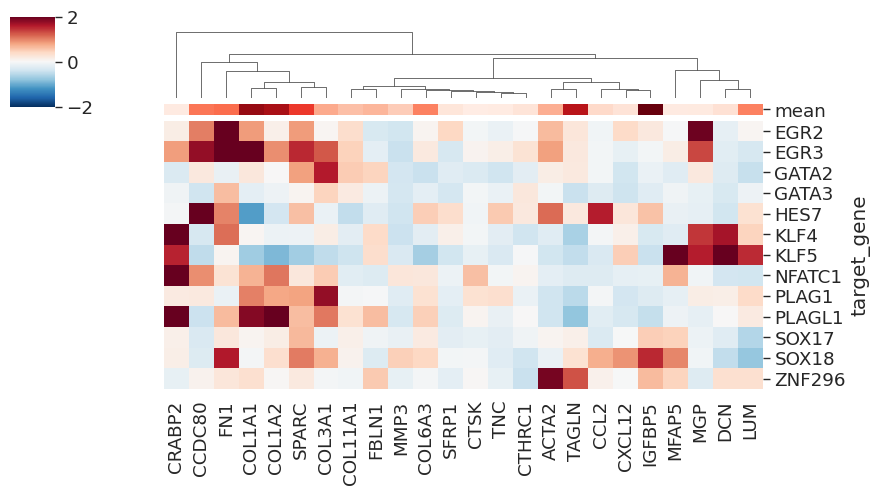

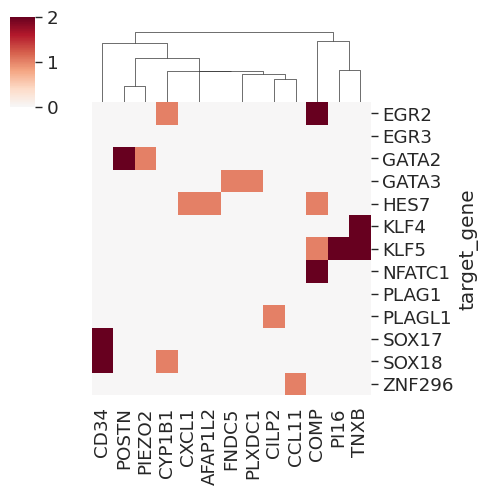

In [343]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_hex
sns.set_context("paper", font_scale = 1.5)


highlights_fibro = ['KLF5_GAAGTTGTGTACAAACTGCG', 'KLF5_GAGCGGAGCGGGTGGAATCT','SOX18_GCCCCCGGGTGGGAAAGAAA',
       'SOX18_GTGCGCGGGGGAGGCCTCAG', 'KLF4_GACGATGGAAGGGAGCCTCG', 'KLF4_GCTCCCTTCCATCGTTGCTA', 
                    'GATA2_GCCGGCCCGCGGGTCAGTCC', 'GATA2_GGGGAGGCCCAGAGCATCGA',
                             'EGR2_GCGGCCGCGCGGACTCCGCC', 'EGR2_GGAGCCCGGCGGAGTCCGCG',
                 'NFATC1_GCAGCAGGGGCGTGATGTCA', 'NFATC1_GGGGGCGTGATGTCACGGCA',
                  'EGR3_GACATTAGAAAGCAGGAAGC',  'EGR3_GAAGGGGCGCGACGTCACAA',
'PLAG1_GGGCGGTGGCCGAACAGGCA',  'PLAGL1_GCTCGGGAGCCGGAACGGCG',
'SOX17_GGCGCCGCGTCCTCTCCCAC', 'SOX17_GTGGGGTTGGACTGGGACGT',
                    'GATA3_GAGCCTGGCGCTGGCGAGTA',
       'GATA3_GGCGCTGGCGAGTAGGGGAC',
                    'HES7_GCCTCGTGCCGGGTCCTAGA', 'HES7_GATTCTGCCCCTCTAGGACC',
                    'ZNF296_GACACTGCCTAGATTGAGTT',
                    'ZNF296_GTTGAGTTAGGCCGCCGTCA'
                    #'GATA4_GCGCAGGCTGCGGGACTGTG'
                   ]


sig_marker_change = marker_gene_expr_filter(coef_pops, 'fibro_a', 
                                            cells = highlights_fibro,
                                            marker_genes = highly_variable_markers2, #minimal_and_universal, #combined_list_fibro,
                                            sig_filter=False, 
                                            value_filter = True, min_change=-0.05, max_change=0.05)


marker_activation = marker_gene_expr_filter(pctl_pops, 'fibro_a', 
                                            cells =sig_marker_change.index,
                                            marker_genes =state_markers100,
                                            normalized_matrix = 'pctl_expr',
                                            sig_filter=False, 
                                            value_filter = False)

expressed_to_plot = sig_marker_change.columns

avg_expr = coef_pops['fibro_a'].genes.query("gene_name in @expressed_to_plot")
avg_expr = avg_expr.set_index('gene_name')['mean']

log2_avg_expr = np.log2(avg_expr+1)

#groupby target and take mean
sig_marker_change['target_gene'] = sig_marker_change.index.str.split("_").str[0]
marker_activation['target_gene'] = marker_activation.index.str.split("_").str[0]

sig_marker_change_target = sig_marker_change.groupby('target_gene').mean()
marker_activation_target = marker_activation.groupby('target_gene').apply(lambda x :(x > 0).sum())


# Map 'log2_avg_expr' values to colors
norm = plt.Normalize(0, log2_avg_expr.max())
cmap = sns.color_palette("Reds", as_cmap=True)
col_colors = pd.DataFrame(log2_avg_expr.apply(lambda x: cmap(norm(x))), index=log2_avg_expr.index)


# Generate the first clustermap with 'sig_marker_change_filtered'
g1 = sns.clustermap(sig_marker_change_target, 
               method='ward',
               row_cluster=False, 
               #robust=True,
               cmap='RdBu_r',
                vmax = 2,
                    vmin = -2,
               figsize = (9,5), col_colors=col_colors,
               center=0)

# Rotate row labels to be horizontal
plt.setp(g1.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)  # Set rotation to 0 degrees


plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240412_fig5_expression_variation_on_fibro_markers_hand_selected.svg')

g1 = sns.clustermap(marker_activation_target.fillna(0), 
               method='ward',
               row_cluster=False, 
               #robust=True,
               cmap='RdBu_r',
               figsize = (5,5),
               center=0
                   )

# Rotate row labels to be horizontal
plt.setp(g1.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)  # Set rotation to 0 degrees


plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240412_fig5_expression_activation_on_fibro_markers_hand_selected.svg')


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_hex

# Set context for the plots
sns.set_context("paper", font_scale=1.5)

# Assuming log2_avg_expr is calculated as previously defined
norm = Normalize(vmin=log2_avg_expr.min(), vmax=log2_avg_expr.max())
cmap = sns.color_palette("Reds", as_cmap=True)
expr_colors = pd.Series([to_hex(cmap(norm(value))) for value in log2_avg_expr], index=log2_avg_expr.index)

# Define gene groups and corresponding colors
group_colors = {
    'inflammatory-Buechler_2021': '#864D9E',
    'inflammatory-Korsunsky_2022': '#AE5981',
    'universal-Buechler_2021': '#376ADC',
    'universal-Korsunsky_2022': '#528FF0',
    'Smith_2023': '#D99828'
}

# Initialize an empty DataFrame for combined group colors
combined_group_colors = pd.DataFrame(index=sig_marker_change_target.columns)

# Fill the DataFrame with the color for each group
for group_name, genes in markers_dict.items():
    # Create a column for each group
    combined_group_colors[group_name] = [group_colors[group_name] if gene in genes else 'white' for gene in combined_group_colors.index]

# Add the expression colors as the last column
combined_group_colors['Expression Color'] = expr_colors.reindex(combined_group_colors.index)

# Now you have a DataFrame where each column represents a group and the last column is the expression color

import scipy.cluster.hierarchy as sch

# Compute the linkage matrix using scipy
row_linkage = sch.linkage(sig_marker_change_target,metric = 'correlation', method='average', optimal_ordering=True)
col_linkage = sch.linkage(sig_marker_change_target.T, metric = 'correlation', method='average', optimal_ordering=True)


# Generate the first clustermap using the calculated linkage matrix
g1 = sns.clustermap(sig_marker_change_target, row_linkage=row_linkage, col_linkage=col_linkage,
                    cmap='RdBu_r', figsize=(10,7), col_colors=combined_group_colors,
                    vmax=2, vmin=-2, center=0)
plt.setp(g1.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# Extract the row order from the first clustermap
row_order = g1.dendrogram_row.reordered_ind

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240417_fig5_expression_variation_on_fibro_markers_hand_selected.svg')

# Extract the row order from the dendrogram
row_order = g1.dendrogram_row.reordered_ind

# Reorder the 'marker_activation_target' to match the row order from the first clustermap
marker_activation_target_ordered = marker_activation_target.iloc[row_order, :]


# Initialize an empty DataFrame for combined group colors for the second dataset
combined_group_colors_activation = pd.DataFrame(index=marker_activation_target.columns)

# Fill the DataFrame with the color for each group
for group_name, genes in markers_dict.items():
    # Create a column for each group
    combined_group_colors_activation[group_name] = [group_colors[group_name] if gene in genes else 'white' for gene in combined_group_colors_activation.index]

# Add the expression colors as the last column - align with the current index
combined_group_colors_activation['Expression Color'] = expr_colors.reindex(combined_group_colors_activation.index)


g2 = sns.clustermap(marker_activation_target_ordered.fillna(0), method='ward', row_cluster=False,
                    cmap='BrBG', figsize=(7,7), col_colors=combined_group_colors_activation, center=0)
plt.setp(g2.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240417_fig5_expression_activation_on_fibro_markers_hand_selected.svg')

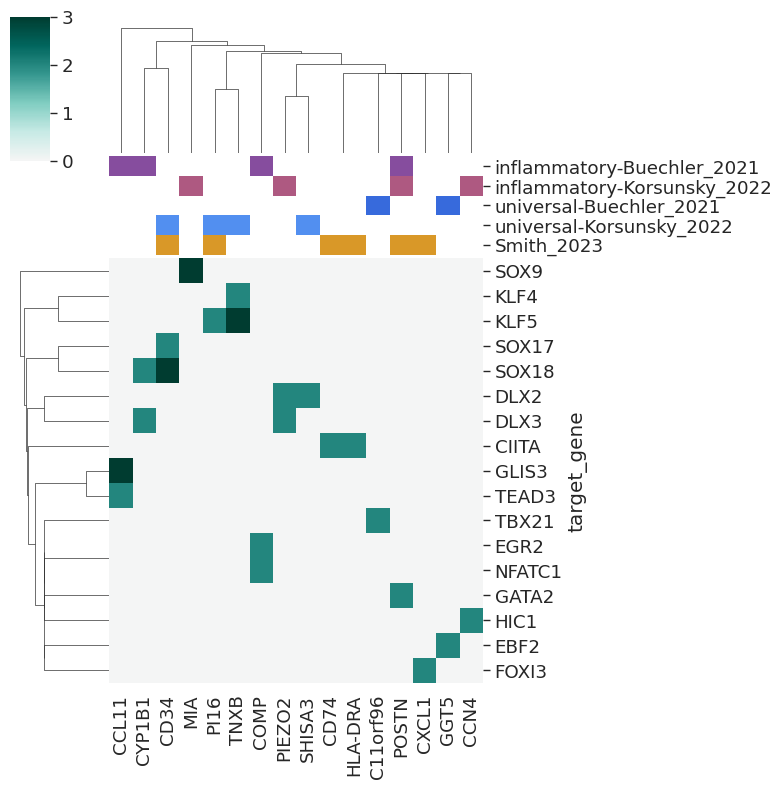

In [302]:
marker_activation = marker_gene_expr_filter(pctl_pops, 'fibro_a', 
                                            cells ='good_guide',
                                            marker_genes = state_markers100,#,+ #['COMP', 'PI16', 'ASPN'],
                                            normalized_matrix = 'pctl_expr',
                                            sig_filter=True, zero_filter = True,
                                            value_filter = False,
                                           filter_rows=True)


marker_activation = marker_activation.where(marker_activation > 0, other = np.nan)
marker_activation['target_gene'] = marker_activation.index.str.split("_").str[0]

marker_activation_target = marker_activation.groupby('target_gene').count()
marker_activation_target_min2 = marker_activation_target[marker_activation_target >= 2].fillna(0)

for column in marker_activation_target_min2.columns:
    if column in marker_activation_target_min2.index:
        marker_activation_target_min2.at[column, column] = 0 # Or any other value or mask you wish to apply

# Remove columns with all zeros
marker_activation_target_filtered_cols = marker_activation_target_min2.loc[:, (marker_activation_target_min2 != 0).any(axis=0)]

# Remove rows with all zeros from the already column-filtered DataFrame
marker_activation_target_filtered = marker_activation_target_filtered_cols.loc[(marker_activation_target_filtered_cols != 0).any(axis=1), :]


# Initialize an empty DataFrame for combined group colors
combined_group_colors = pd.DataFrame(index=marker_activation_target_filtered.columns)

# Fill the DataFrame with the color for each group
for group_name, genes in markers_dict.items():
    # Create a column for each group
    combined_group_colors[group_name] = [group_colors[group_name] if gene in genes else 'white' for gene in combined_group_colors.index]


sns.clustermap(marker_activation_target_filtered, figsize = (8,8), 
               col_colors = combined_group_colors,
               cmap = 'BrBG', center = 0)

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240416_new_marker_genes_activated_in_fibro.svg')

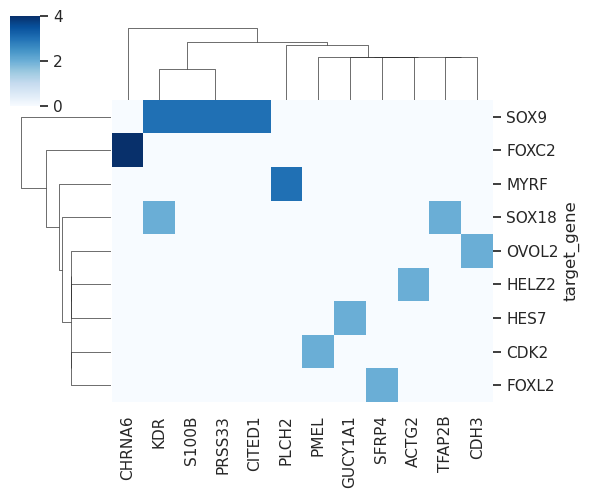

In [704]:
marker_activation = marker_gene_expr_filter(pctl_pops, 'rpe1_a', 
                                            cells ='good_guide',
                                            marker_genes = retina_markers.tolist()+additional_rpe+additional_other,#,+ #['COMP', 'PI16', 'ASPN'],
                                            normalized_matrix = 'pctl_expr',
                                            sig_filter=True, zero_filter = True,
                                            value_filter = False,
                                           filter_rows=True)


marker_activation = marker_activation.where(marker_activation > 0, other = np.nan)
marker_activation['target_gene'] = marker_activation.index.str.split("_").str[0]

marker_activation_target = marker_activation.groupby('target_gene').count()
marker_activation_target_min2 = marker_activation_target[marker_activation_target >= 2].fillna(0)

for column in marker_activation_target_min2.columns:
    if column in marker_activation_target_min2.index:
        marker_activation_target_min2.at[column, column] = 0 # Or any other value or mask you wish to apply

# Remove columns with all zeros
marker_activation_target_filtered_cols = marker_activation_target_min2.loc[:, (marker_activation_target_min2 != 0).any(axis=0)]

# Remove rows with all zeros from the already column-filtered DataFrame
marker_activation_target_filtered = marker_activation_target_filtered_cols.loc[(marker_activation_target_filtered_cols != 0).any(axis=1), :]


# # Initialize an empty DataFrame for combined group colors
# combined_group_colors = pd.DataFrame(index=marker_activation_target_filtered.columns)

# # Fill the DataFrame with the color for each group
# for group_name, genes in markers_dict.items():
#     # Create a column for each group
#     combined_group_colors[group_name] = [group_colors[group_name] if gene in genes else 'white' for gene in combined_group_colors.index]


sns.clustermap(marker_activation_target_filtered, figsize = (6,5), 
               #col_colors = combined_group_colors,
               cmap = 'Blues', #center = 0
              )

plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240416_rpe1_new_marker_genes_activated.svg')

# Universality new genes

In [332]:
outlier_perturbations_universality = ['CEBPA_GGCAGCCTCGGGATACTCCT', 'GSC_GTTCGCTGAACTCAACCCGC',
       'OSR2_GCAAACAGAAGTAAACAGAG', 'OSR2_GGTGGACCATTAGCAGACGC',
       'OSR1_GGGGGAGGAATCCTGAGGCA', 'OSR1_GGGAGGAATCCTGAGGCAAG',
       'OSR2_GGGCGGAGCCAGGGCGCTGA', 'LHX2_GGGCTGTAGAAAAGGCGCGG',
       'FOXA3_GTCGCCAGGAGACAGACCTC', 'HAND1_GGCGGGCTGAGCGTAAAACC',
       'EOMES_GGTCGGCAGGTGGGTAGCCC', 'KLF5_GCCCTACCTAGCTGCCTTCT',
       'HNRNPAB_GGCGCCGTCCCGCCCGGCTT', 'TP73_GTCGGGCACAGAGTCGGCAC',
       'HAND1_GCGGGCTGAGCGTAAAACCT', 'SOX18_GGAGAAGAAAGGGAGCCCCC',
       'KLF5_GAGCGGAGCGGGTGGAATCT', 'SOX18_GTGCGCGGGGGAGGCCTCAG',
       'SOX18_GGACCCCCGGGCAGTAACTG', 'KLF5_GAAGTTGTGTACAAACTGCG',
       'SOX18_GGCCTCAGCGGAATCCCGCC']

In [333]:
markers_universal = {k: markers_dict[k] for k in ['universal-Buechler_2021', 'universal-Korsunsky_2022']}

markers_inflamatory = {k: markers_dict[k] for k in ['inflammatory-Buechler_2021', 'inflammatory-Korsunsky_2022']}

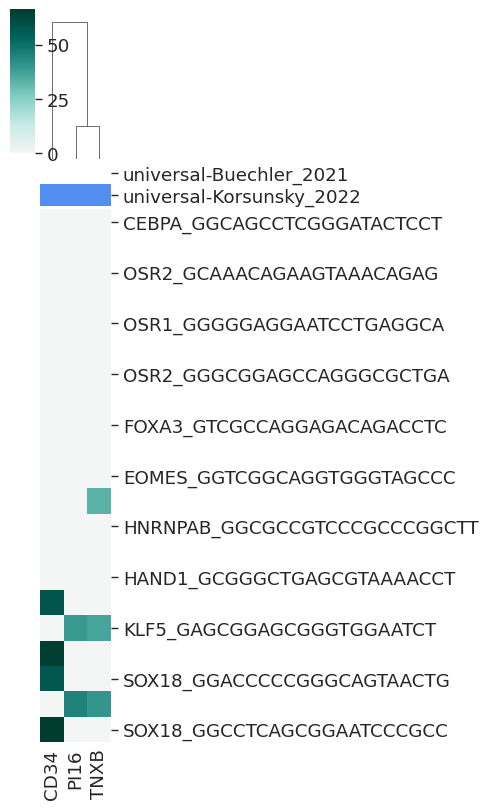

In [336]:
marker_activation = marker_gene_expr_filter(pctl_pops, 'fibro_a', 
                                            cells =outlier_perturbations_universality,
                                            marker_genes = universal_markers100,#,+ #['COMP', 'PI16', 'ASPN'],
                                            normalized_matrix = 'pctl_expr',
                                            sig_filter=True, zero_filter = True,
                                            value_filter = False,
                                           filter_rows=False)


marker_activation = marker_activation.where(marker_activation > 0, other = np.nan)

# Remove columns with all zeros
marker_activation_filtered= marker_activation.loc[:, (marker_activation != 0).any(axis=0)]

# Initialize an empty DataFrame for combined group colors
combined_group_colors = pd.DataFrame(index=marker_activation_filtered.columns)

# Fill the DataFrame with the color for each group
for group_name, genes in markers_universal.items():
    # Create a column for each group
    combined_group_colors[group_name] = [group_colors[group_name] if gene in genes else 'white' for gene in combined_group_colors.index]


g = sns.clustermap(marker_activation_filtered.fillna(0), figsize = (5,8), 
               row_cluster = False,
               col_colors = combined_group_colors,
               cmap = 'BrBG', center = 0)

# Rotate x-axis labels for clarity
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
g.ax_heatmap.xaxis.set_tick_params(pad=0)  # Adjust spacing if needed



plt.savefig('/data/norman/southark/tfs_standardized/figure_exports/20240417_new_marker_genes_activated_in_fibro_universal_program.svg')